# Analyses for the Literature Contextizer Project

Author: Dan Sosa

Updated: 11/07/22

#### Test the CLI

In [1]:
# !/Users/dnsosa/opt/miniconda3/envs/lit_con2/bin/python -m lit_contextizer --no_parse_files --pmc_query_list_path /Users/dnsosa/Desktop/AltmanLab/bai/Stanford-Collab/output/papers_to_extract_features_from.csv --output_folder /Users/dnsosa/Desktop/AltmanLab/bai/Stanford-Collab/notebooks/jake_papers


## Cell Type Context-PPI Association

First, let's load what we need from the `lit_contextizer` package.

In [1]:
# General imports
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Improt from lit_contextizer
from lit_contextizer.classifiers.AnalysisUtilities import include_annotations_in_insider_corpus
from lit_contextizer.data_models.DataLoader import DataLoader
from lit_contextizer.data_models.DataLoaderUtilities import create_dengue_corpus
from lit_contextizer.data_models.PaperUtilities import extract_features
from lit_contextizer.data_models.Utilities import load_all_groundings
from lit_contextizer.classifiers.VisualizationUtilities import draw_CTs_in_mesh_counts, draw_section_distribution, generate_analysis_figs, plot_benchmark_fig, plot_con_mention_frac_precision_plots, plot_dengue_networks, plot_mac_hep_neu_venn

# Pandas configs
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.options.display.max_columns = None

# Matplotlib parameters
SMALL_SIZE = 24
MEDIUM_SIZE = 35
BIGGER_SIZE = 40
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['legend.title_fontsize'] = SMALL_SIZE

# Directories from which to read results and output figures
pwd = os.path.dirname(os.path.abspath('__file__'))
processed_papers_dir = "new_NER_v2"  # NOTE: May need to change this if processed papers are elsewhere
out_dir = os.path.abspath(os.path.join(pwd, f'../output/{processed_papers_dir}'))
fig_out_dir = os.path.abspath(os.path.join(pwd, f'../output/manuscript_figures/FINAL'))

# Create the main data loader object
dl = DataLoader()
print("Done initializing")

# Load all the extracted relations. Load the identified contexts into the DataLoader.
dl.all_pubmed_relations_df = pd.read_csv(os.path.join(out_dir, "all_pubmed_relations_citationDist_v2.tsv"), sep='\t').astype({'pmid': 'string'})
#dl.annot_id2entrez = json.load(open(f'{out_dir}/annot_id2entrez.csv'))
#dl.annot_id2text = json.load(open(f'{out_dir}/annot_id2text.csv'))
dl.pmid2contexts = json.load(open(f'{out_dir}/pmid2contexts.csv'))
dl.contexts2pmid = json.load(open(f'{out_dir}/contexts2pmid.csv'))
#dl.pmid2species = json.load(open(f'{out_dir}/pmid2species.csv'))


/Users/dnsosa/opt/miniconda3/envs/lit_con2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Done initializing


Let's see how many papers and relations we have in our dataset.

In [2]:
# Stats on papers and relations
print(f"Number of unique papers (PMID): {len(set(dl.all_pubmed_relations_df.pmid))}")
print(f"Number of unique papers (PMCID): {len(set(dl.all_pubmed_relations_df.pmcid))}")
print(f"\nNumber of unique relations: {len(set(dl.all_pubmed_relations_df.rel))}")

Number of unique papers (PMID): 75001
Number of unique papers (PMCID): 75001

Number of unique relations: 131707


First, cell type (CT). We'll load the CT insider corpus sentences, then we'll load the features from CT insider papers that we've previously calculated. Finally, we'll use both to get our annotations (y values) for our features.

In [3]:
insider_context_type = "CTs"

# Create the corpus of CT insider sentences 
insider_df_CTs = dl.create_insider_corpus(context_type=insider_context_type)

# Load features from the insider papers found in the processed directory (previously extracted)
insider_df_CT_features_path = os.path.join(out_dir, "CTs_insider_papers_features_df.tsv")
insider_df_CT_features = pd.read_csv(insider_df_CT_features_path, sep='\t')

# Include the annotations given the insider sentences and the extracted features
insider_df_CT_features_annots = include_annotations_in_insider_corpus(insider_df_CTs, insider_df_CT_features)

Number of unique papers with inside sentences --  plasma cell: 7
Number of unique papers with inside sentences --  mesenchymal stem cell: 8
Number of unique papers with inside sentences --  plasmacytoid dendritic cell: 5
Number of unique papers with inside sentences --  immature natural killer cell: 1
Number of unique papers with inside sentences --  granulocyte: 2
Number of unique papers with inside sentences --  cardiac muscle cell: 2
Number of unique papers with inside sentences --  thymocyte: 17
Number of unique papers with inside sentences --  platelet: 18
Number of unique papers with inside sentences --  erythroid progenitor cell: 2
Number of unique papers with inside sentences --  retinal pigment epithelial cell: 6
Number of unique papers with inside sentences --  hematopoietic stem cell: 6
Number of unique papers with inside sentences --  mesothelial cell: 4
Number of unique papers with inside sentences --  neutrophil: 80
Number of unique papers with inside sentences --  smooth

In which sections do the contexts and relations fall? How many of those contexts were also found in a MeSH heading? 

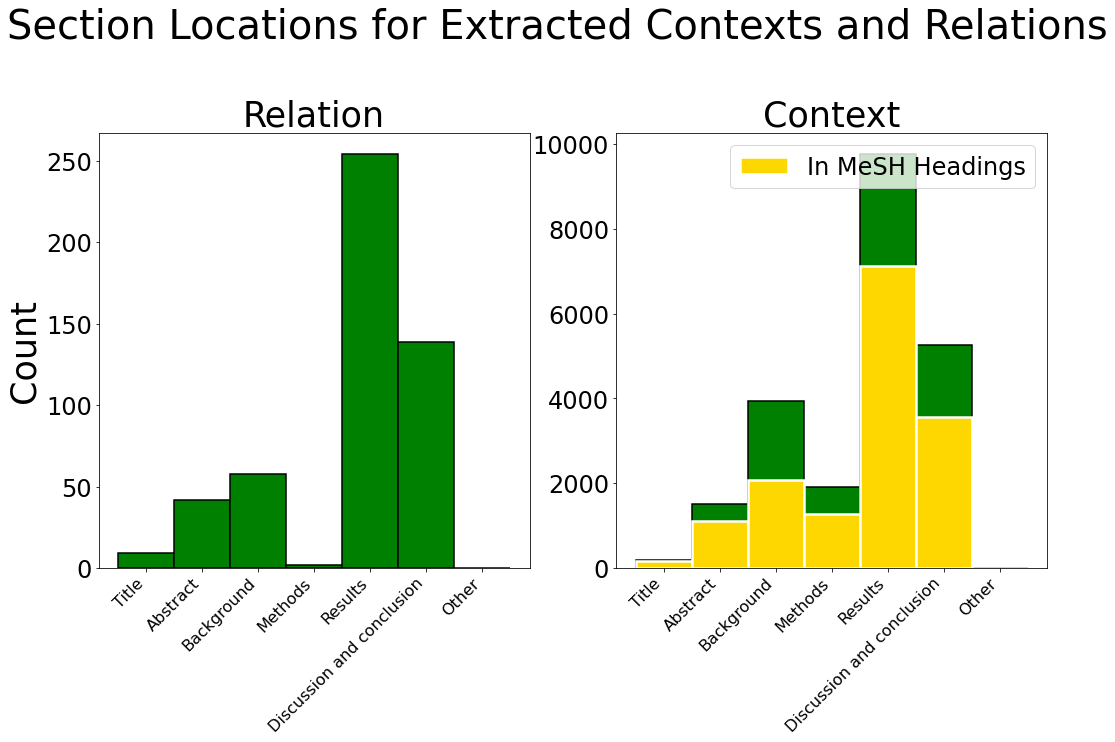

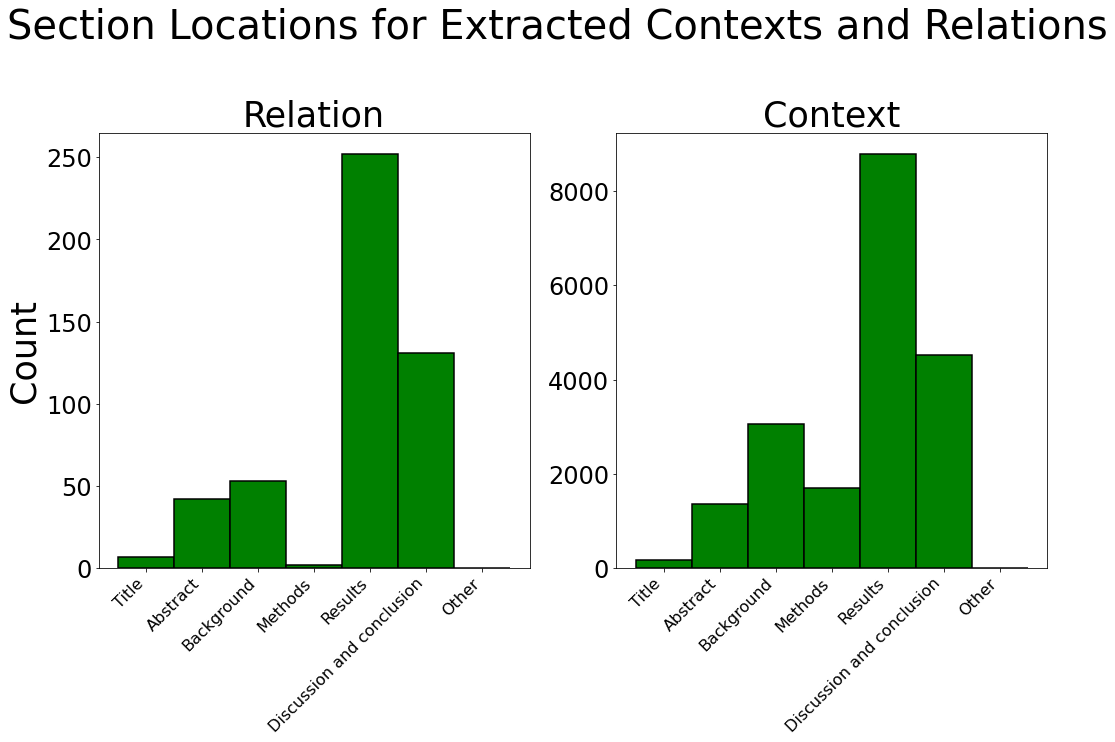

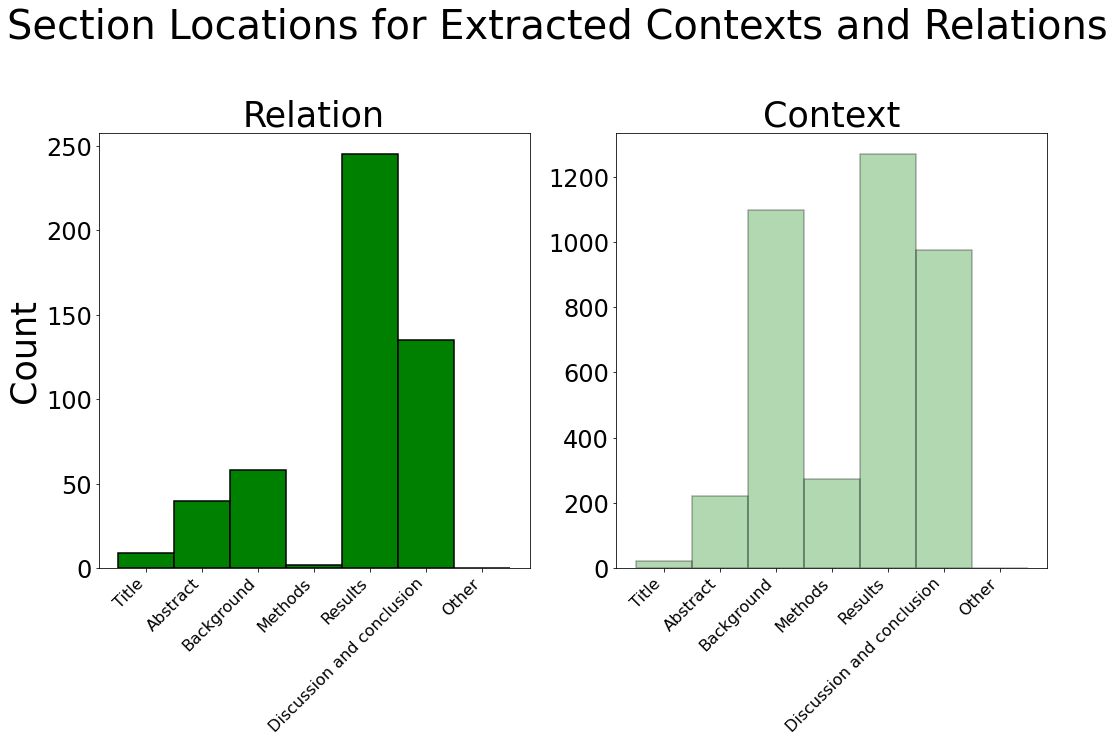

In [4]:
# Plot distributions. Note: plotting by individual mention in text, not by context generally (i.e. counts account for all mentions of 'hepatocyte' in a text)

draw_section_distribution(insider_df_CT_features_annots, in_mesh=True, out_dir=fig_out_dir, filename="InsiderCTAll")
draw_section_distribution(insider_df_CT_features_annots[insider_df_CT_features_annots.annotation], in_mesh=False, out_dir=fig_out_dir, filename="InsiderCTPos")
draw_section_distribution(insider_df_CT_features_annots[~insider_df_CT_features_annots.annotation], in_mesh=False, alpha=.3, out_dir=fig_out_dir, filename="InsiderCTNeg")

What is the relationship between "commonness" of the term and its appearance as a MeSH term. Namely, are really common terms (e.g. "macrophage") more likely to be annotated as a MeSH heading. Or maybe are really rare terms so significant as central topics that if they ever appear, they're a MeSH term in a paper? Let's explore what how correlated these variables are.

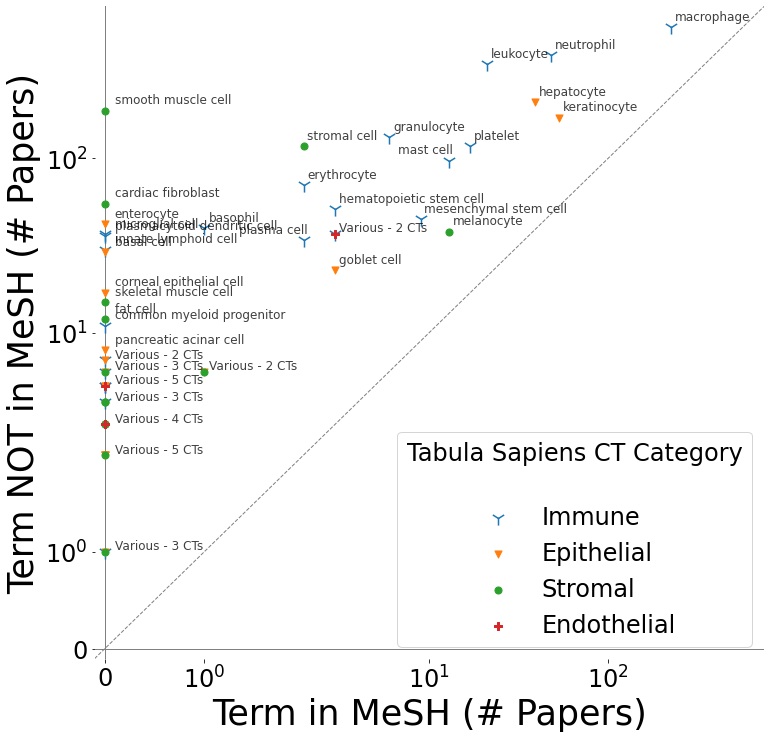

In [5]:
draw_CTs_in_mesh_counts(insider_df_CT_features, out_dir=fig_out_dir, filename="Insider")

Okay, now we're ready to train our classifiers--let's see some results!

N negatives: 1130
N positives: 491
Total len of resulting DF: 1621


N negatives - after up/down-weighting: 491
N positives - after up/down-weighting: 491
Total len of resulting DF: 982
Initializing list of untrained models...
Fitting model: Logistic Reg
Fitting model: SVC - Linear
Fitting model: Random Forest
Fitting model: Feedforward Neural Net


/Users/dnsosa/opt/miniconda3/envs/lit_con2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Fitting model: Gradient Boosted Trees
Looking at clf: Logistic Reg
Accuracy 0.9390243902439024
Looking at clf: SVC - Linear
Accuracy 0.9298780487804879
Looking at clf: Random Forest
Accuracy 0.9542682926829268
Looking at clf: Feedforward Neural Net
Accuracy 0.948170731707317
Looking at clf: Gradient Boosted Trees
Accuracy 0.948170731707317


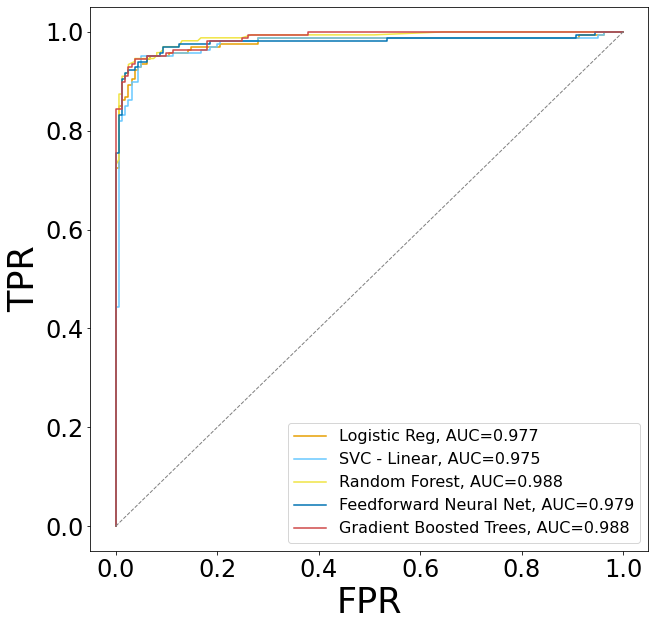

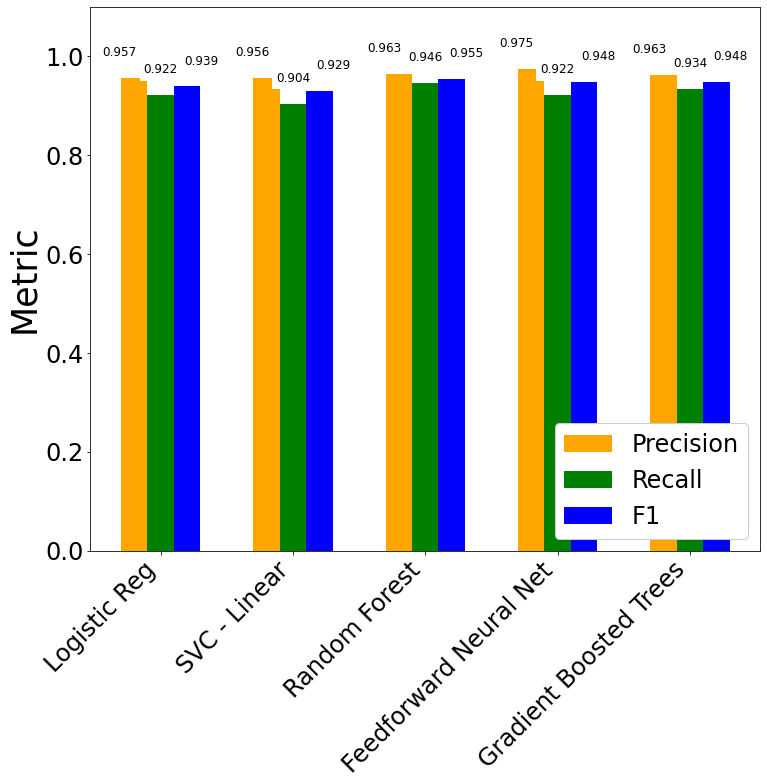

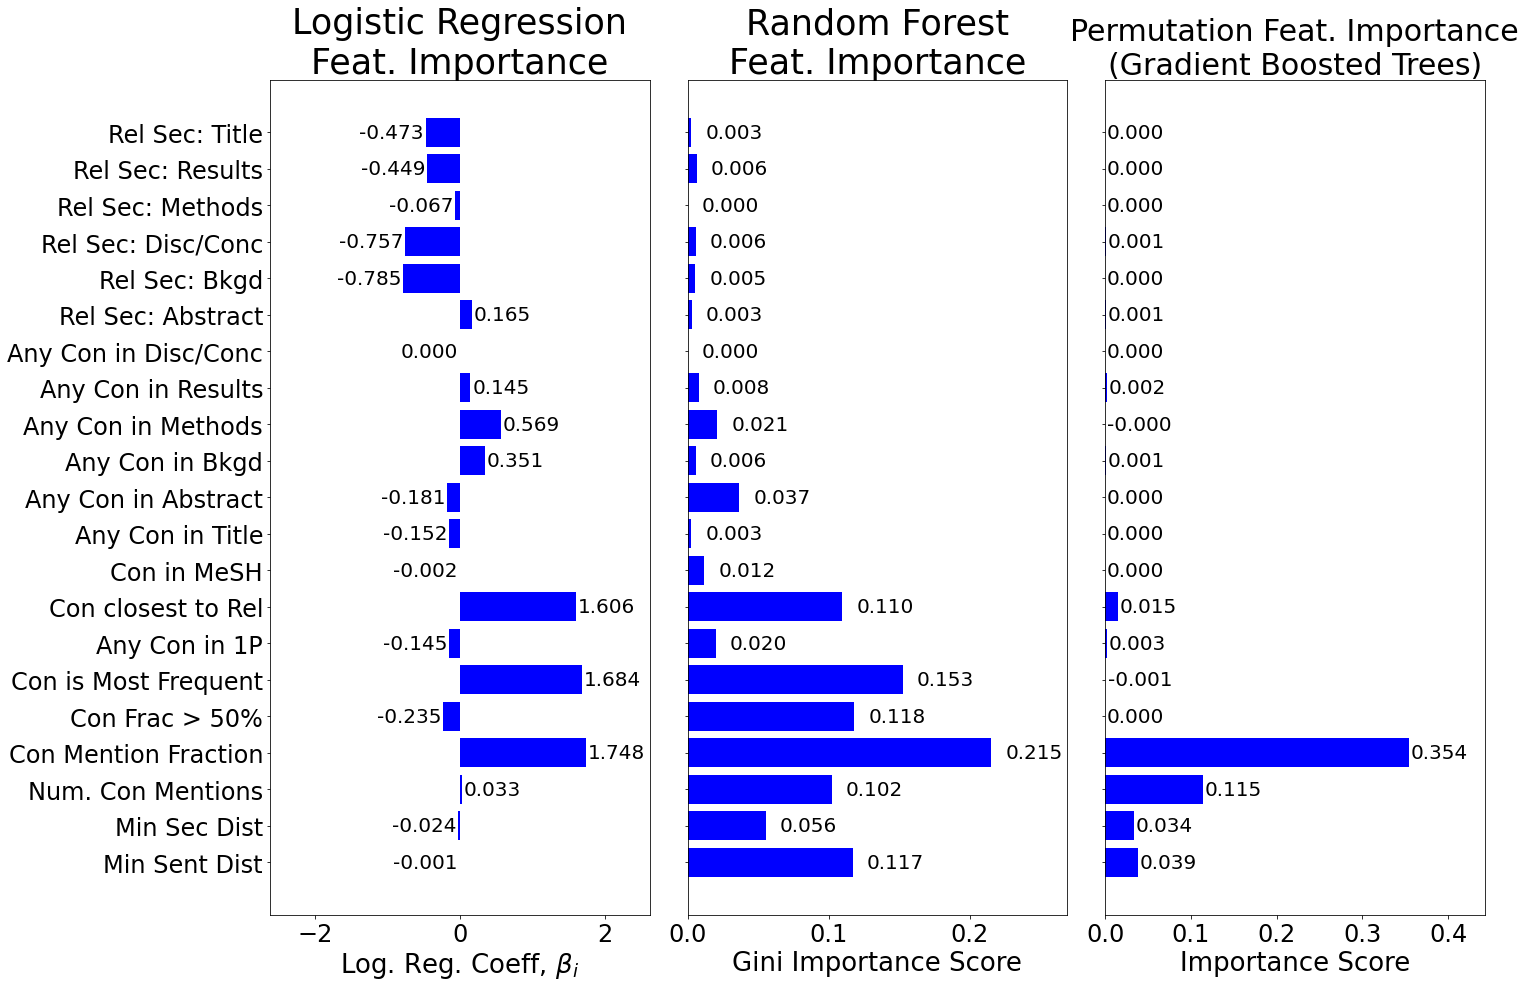

In [7]:
insider_CT_res_df, insider_CT_clf_list, insider_CT_predictions_df = generate_analysis_figs(insider_df_CT_features_annots, 
                                                                                           grouped_analysis=True,
                                                                                           downsample_maj=True,
                                                                                           upsample_min=False,
                                                                                           weight_imbalance=False,
                                                                                           plot_roc_curve=True,
                                                                                           plot_confusion_matrices=False,
                                                                                           plot_feature_analysis=True,
                                                                                           out_dir=fig_out_dir,
                                                                                           filename="insiderCT")


How far are our positive contexts away from the relation (excluding the context mention inside the insider of course)?

Number positive CTs with min sentence distance <= 5: 399 (81.3%)
Number positive CTs with min sentence distance >= 10: 60 (12.2%)


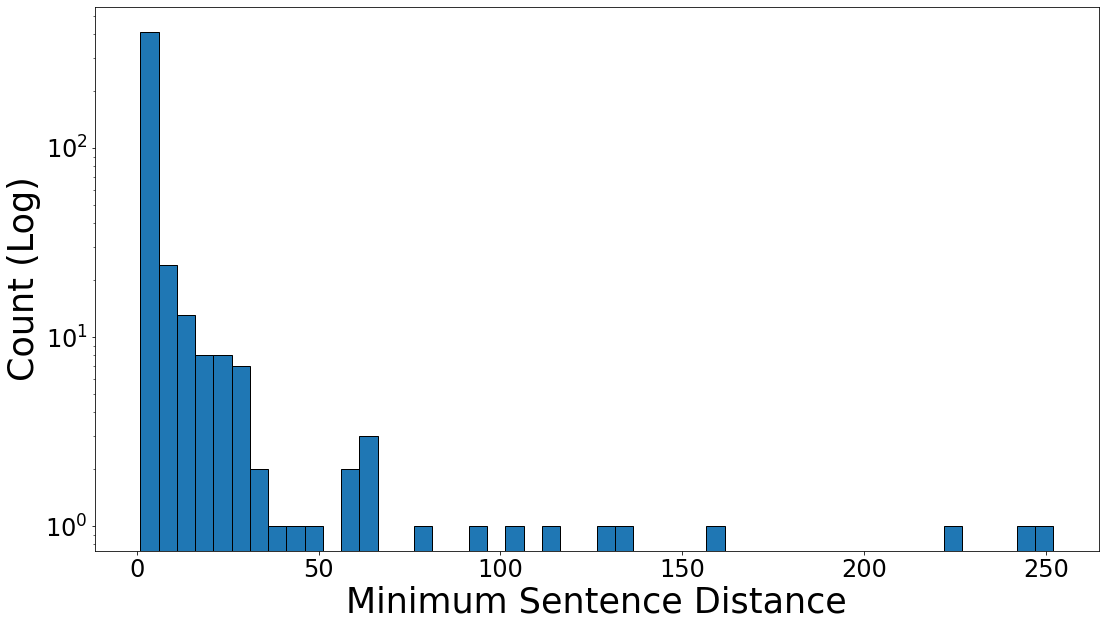

In [10]:
# Count the sentence distances within certain bounds
low_bound = 5
up_bound = 10
n_pos = len(insider_CT_res_df[insider_CT_res_df.annotation])
pos_within_lb = len(insider_CT_res_df[(insider_CT_res_df.annotation) & (insider_CT_res_df.min_sent_dist <= low_bound)])
pos_gt_ub = len(insider_CT_res_df[(insider_CT_res_df.annotation) & (insider_CT_res_df.min_sent_dist >= up_bound)])

print(f"Number positive CTs with min sentence distance <= {low_bound}: {pos_within_lb} ({round(pos_within_lb / n_pos, 3)*100}%)")
print(f"Number positive CTs with min sentence distance >= {up_bound}: {pos_gt_ub} ({round(pos_gt_ub / n_pos, 3)*100}%)")

# Plot the distribution of sentence distances
fig = plt.figure(figsize=(18, 10))

positives_sent_dists = np.array(insider_CT_res_df[insider_CT_res_df.annotation].min_sent_dist)
plt.hist(positives_sent_dists, edgecolor="black", bins=50)
plt.yscale('log')
plt.ylabel('Count (Log)')
plt.xlabel('Minimum Sentence Distance')

# Save file
out_file = os.path.join(fig_out_dir, f"MinSentDist_PositiveInsiderCT.png")
plt.savefig(out_file, dpi=300, bbox_inches="tight")
plt.show()

And we can check out some examples where the context is far away

In [11]:
insider_CT_res_df[insider_CT_res_df.annotation & (insider_CT_res_df.min_sent_dist >= 10)].head(3)

,rel,con,min_sent_dist,min_sec_dist,num_con_mentions,con_mention_frac,con_mention_50,is_con_mention_max,any_con_fp,is_closest_cont_by_sent,con_in_mesh_headings,norm_rel_sec,any_con_title,any_con_abstract,any_con_background,any_con_methods,any_con_results,any_con_disc_conc,annotation
569,"Notably, we find that Wnt4 suppresses Tak1 activation induced by Rankl, resulting in the inhibition of IKK/NF-κB activation in macrophages and osteoclast precursors.",macrophage,29.0,6.0,20,0.952381,True,True,True,True,0,discussion and conclusion,False,True,False,False,True,False,True
769,"Furthermore, DKK1 induces the expression of keratin 9 and α-Kelch-like ECT2 interacting protein (αKLEIP) but down-regulates the expression of β-catenin, glycogen synthase kinase 3β, protein kinase C and proteinase-activated receptor-2 (PAR-2) in keratinocytes.",keratinocyte,19.0,6.0,18,0.580645,True,True,True,False,1,abstract,False,False,True,False,False,False,True
801,"Using Western blotting, we confirmed an upregulation of MT1-MMP by C5a in leukocytes and MNC.",leukocyte,12.0,3.0,11,0.323529,False,False,True,False,0,results,False,False,False,True,True,False,True


In [162]:
#### DELETE ME!!!


set(dl.all_pubmed_relations_df[dl.all_pubmed_relations_df.distance_to_nearest_sentence_with_citation > 0].head(100).rel)




{'Akt is a downstream mediator of PI3K and the growth factor receptor (GFR) stimulation of Akt has been shown to be dependent on PI3K activity.',
 'Although p62 alone increased the expression of GluR1 at the cell surface, inclusion of active aPKC resulted in a significant increase in GluR1 at the cell surface.',
 'Although we found that 15-HC can use the same pathway to activate PARP-1 in a cell-free system, our results have shown that TLR2 was required for the activation of PARP-1 by 15-HC in living cells in vitro and in vivo .',
 'As predicted, the MEK/ERK inhibitor U1026 and the pKa inhibitor H89 each attenuated the induction of PPARδ ( Fig. 2B ) and phospho-Rb (unpublished data) by EGF and TSH treatment, respectively.',
 'As shown in Figure 6B,D , ATF4 dose-dependently stimulated cyclin D1 expression both at the mRNA and protein level.',
 'Because Irgm1 itself is strongly induced by IFN-γ, we propose that it provides a positive feedback mechanism in the IFN-γ signaling pathway that

It's interesting to see what went wrong. Here are some false positives and false negatives.

In [12]:
# Error analysis

error_df_fns = insider_CT_predictions_df[(insider_CT_predictions_df.Label != insider_CT_predictions_df["Pred: Random Forest"]) & insider_CT_predictions_df.Label]
error_df_fps = insider_CT_predictions_df[(insider_CT_predictions_df.Label != insider_CT_predictions_df["Pred: Random Forest"]) & ~insider_CT_predictions_df.Label]

# The following were found from a head of both of the above dataframes
#insider_df_CTs[insider_df_CTs.PMCID == 'PMC2884222']
#insider_df_CTs[insider_df_CTs.PMCID == 'PMC3849919']
#insider_df_CTs[insider_df_CTs.PMCID == 'PMC6103837']

#insider_df_CTs[insider_df_CTs.PMCID == 'PMC3561241']
#insider_df_CTs[insider_df_CTs.PMCID == 'PMC4644191']
#insider_df_CTs[insider_df_CTs.PMCID == 'PMC6864939']

It's also interesting to see how well our trained models do against simple benchmarks. Let's compare our best trained model to the benchmarks.

Looking at benchmark: any_rel_con_section_match
Accuracy 0.6629327902240326
Looking at benchmark: is_con_mention_max
Accuracy 0.9276985743380856
Looking at benchmark: con_mention_50
Accuracy 0.9154786150712831
Looking at benchmark: con_in_mesh_headings
Accuracy 0.7525458248472505
Looking at benchmark: min_sent_dist_1
Accuracy 0.7342158859470469
Looking at benchmark: min_sent_dist_2
Accuracy 0.8228105906313645
Looking at benchmark: min_sent_dist_3
Accuracy 0.8421588594704684
Looking at benchmark: min_sent_dist_4
Accuracy 0.8492871690427699
Looking at benchmark: min_sent_dist_5
Accuracy 0.8564154786150713
Looking at benchmark: min_sent_dist_6
Accuracy 0.8615071283095723


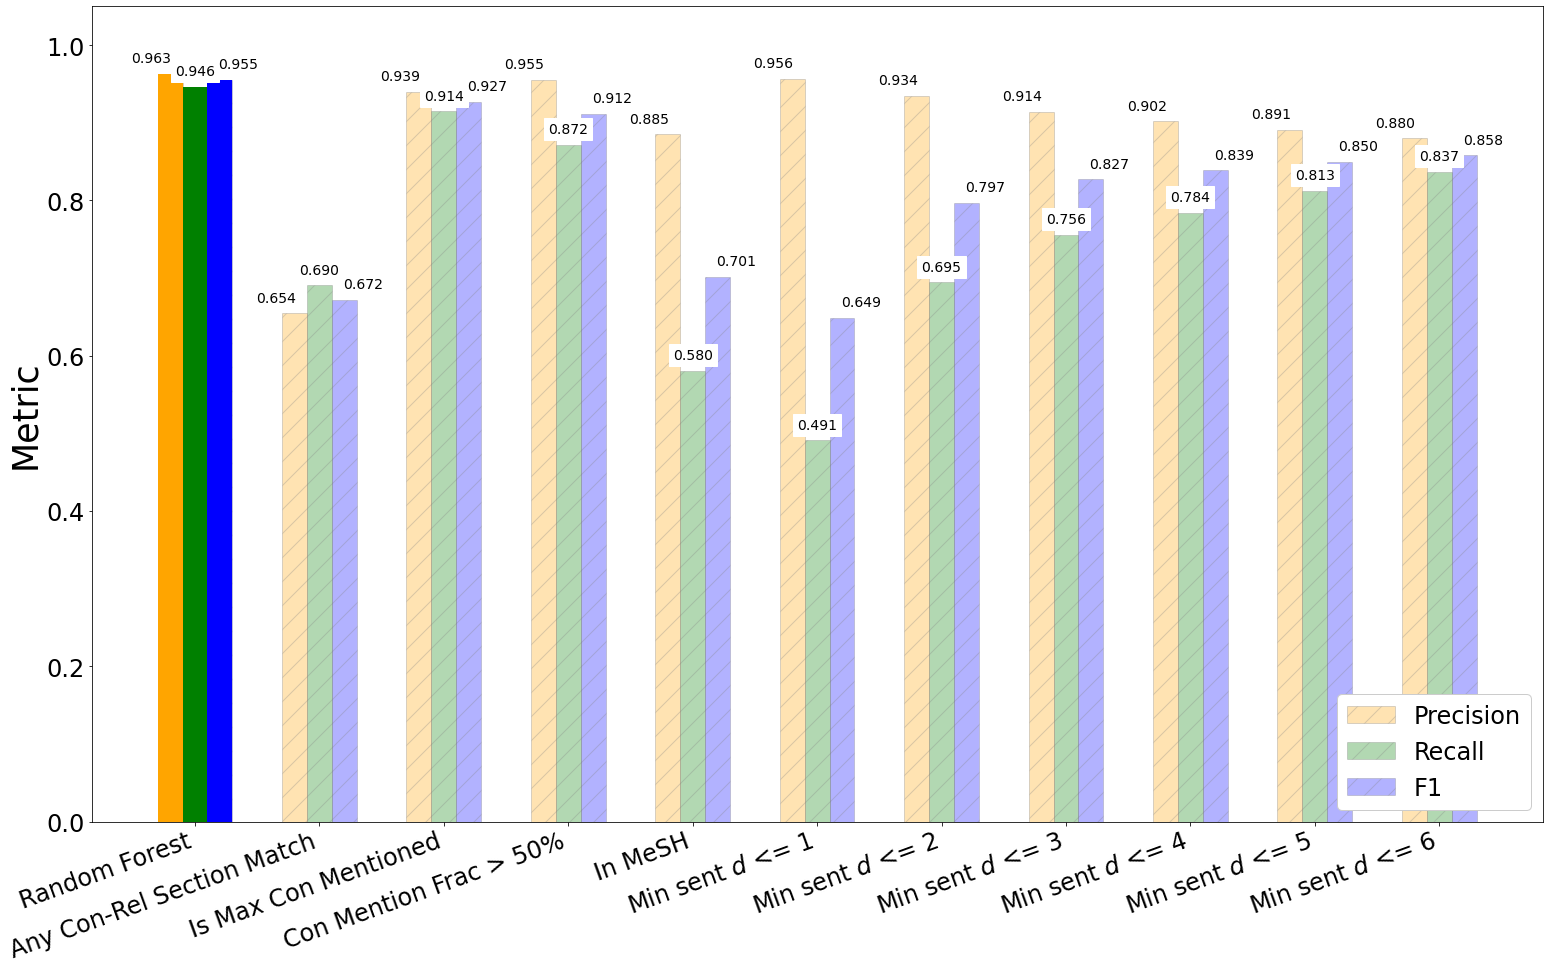

In [13]:
plot_benchmark_fig(insider_CT_res_df, 
                   best_model_name="Random Forest", 
                   best_model_stats=[0.963, 0.946, 0.955],
                   out_dir=fig_out_dir,
                   filename="insiderCT")

In [70]:
insider_df_tissues.head(50)

,Extracted Relation,Context,All Tabula Contexts in Paper,PMCID,Entity 1 Text,Entity 2 Text,Citation Dist
0,"Therefore, we conclude that PCNAP1 enhances the expression of PCNA at post-transcriptional level in liver.",liver,"['liver', 'blood', 'lung']",PMC6691589,PCNAP1,PCNA,8.0
1,"In vivo , reducing Ezrin also suppressed p65 expression in lungs and livers of osteosarcoma mice.",lung,"['liver', 'tongue', 'lung']",PMC5907830,Ezrin,p65,2.0
2,"Loss of Tgfbr2 prevented MSCs from sustaining a TGFβ1 induced αSMA expression and conversion to myofibroblasts when compared to control cells ( Fig. 3d–e ), further supporting the notion that TGFβ1 may play a role in differentiation of MSCs into myofibroblasts in kidney fibrosis.",kidney,"['bone marrow', 'lung', 'kidney', 'blood']",PMC4067127,TGFβ1,αSMA,5.0
3,"However, mTORC1 activity, monitored by its target S6K, was similar between Con and Sesn2 −/− mice ( Figure S3K ), and insulin induced AKT activation in liver ( Figure S3L ) and in adipose tissue ( Figure S3M ) was also comparable between lean Con and Sesn2 −/− mice.",adipose tissue,"['muscle tissue', 'adipose tissue', 'liver', 'blood']",PMC3687365,insulin,AKT,NaN
4,We found that SAA decreased the expression of PU.1 and C/EBPα in bone marrow cells ( Figure 3d ).,bone marrow,"['bone marrow', 'liver', 'blood']",PMC5579511,SAA,PU.1,1.0
5,The results showed that SP upregulates COL1A1 gene expression in corneal fibroblasts both 2 days and 4 days after treatment.,cornea,"['cornea', 'eye', 'liver']",PMC6746877,SP,COL1A1,NaN
6,"Based on the function of ZHX2 as a transcriptional repressor and its known interaction with NF-YA, we hypothesized that ZHX2 might inhibit MDR1 expression in liver cancer cells, resulting in reduced efflux of chemotherapeutic drugs and subsequent increased sensitivity to these agents.",liver,"['liver', 'kidney']",PMC4359216,ZHX2,MDR1,NaN
7,IL-13 significantly increased Muc5AC mRNA levels in lungs of WT mice after 24 hours of IL-13 treatment ( Figure 8A ).,lung,"['lung', 'trachea']",PMC5612446,IL-13,Muc5AC,NaN
8,"As shown in Figure 5E , F , KRT8 suppressed the expression of Twist1, VEGFR and MMP2 in lung cancer cells at both mRNA level and protein level.",lung,"['blood', 'lung']",PMC7132007,KRT8,Twist1,NaN
9,The present study demonstrated that HOXB6 inhibited SOX9 + LPC proliferation and differentiation by reducing SOX9 levels in liver injury repair.,liver,"['bone marrow', 'kidney', 'liver', 'blood']",PMC7486193,HOXB6,SOX9,1.0


#### Transfer to Insider Tissue Analysis

Now, we'll take our pipeline for cell types and see how well it does on a different context--tissues

Number of unique papers with inside sentences --  parotid gland: 1
Number of unique papers with inside sentences --  endometrium: 3
Number of unique papers with inside sentences --  muscle tissue: 2
Number of unique papers with inside sentences --  thymus: 6
Number of unique papers with inside sentences --  tongue: 4
Number of unique papers with inside sentences --  submandibular gland: 2
Number of unique papers with inside sentences --  adipose tissue: 73
Number of unique papers with inside sentences --  cornea: 18
Number of unique papers with inside sentences --  trachea: 3
Number of unique papers with inside sentences --  coronary artery: 3
Number of unique papers with inside sentences --  spleen: 13
Number of unique papers with inside sentences --  conjunctiva: 3
Number of unique papers with inside sentences --  kidney: 44
Number of unique papers with inside sentences --  sclera: 1
Number of unique papers with inside sentences --  blood: 33
Number of unique papers with inside sente

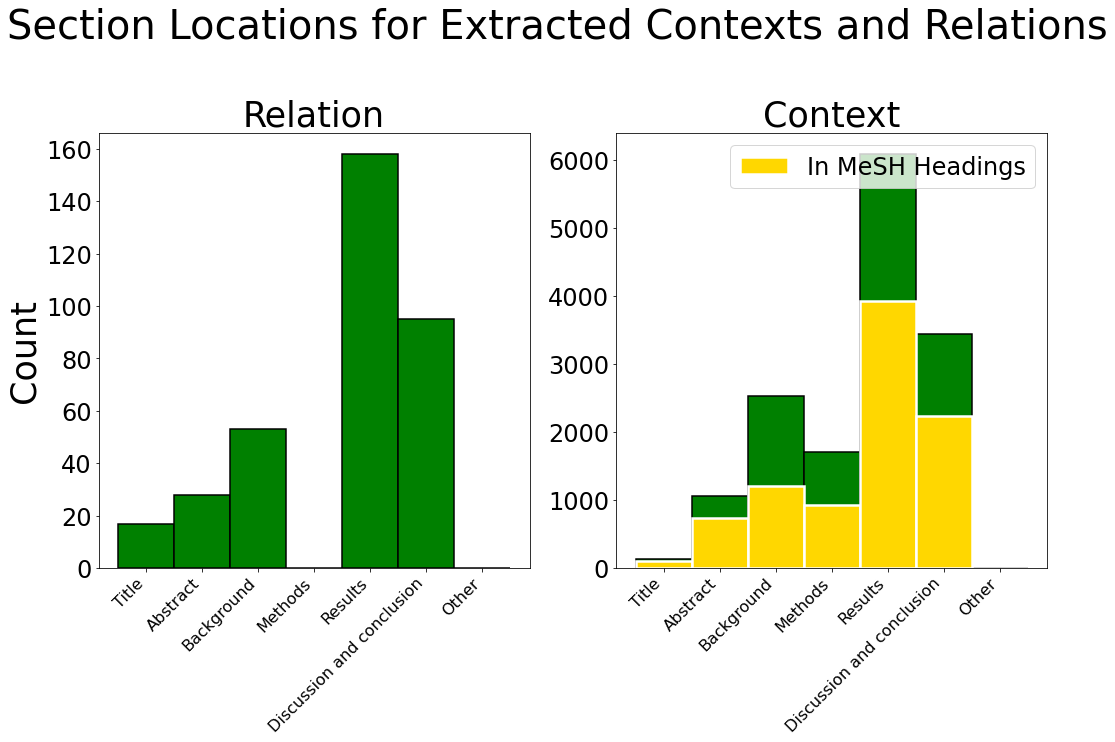

In [14]:
#insider_df_tissue_features_path = "/Users/dnsosa/Desktop/AltmanLab/bai/Stanford-Collab/output/new_NER_v2/tissues_insider_papers_features_df.tsv"

# Load the previously extracted features
insider_df_tissue_features_path = os.path.join(out_dir, "tissues_insider_papers_features_df.tsv")
insider_df_tissue_features = pd.read_csv(insider_df_tissue_features_path, sep='\t')

# Generate the Insider corpus
insider_df_tissues = dl.create_insider_corpus(context_type="tissues")

# Combine the two to label the featurized papers based on Insider sentences
insider_df_tissue_features_annots = include_annotations_in_insider_corpus(insider_df_tissues, insider_df_tissue_features)

# Visualize the section distributions
draw_section_distribution(insider_df_tissue_features_annots, 
                          out_dir=fig_out_dir, 
                          filename="insiderTissues")


Run the same classification pipeline as before, now for tissues

N negatives: 822
N positives: 344
Total len of resulting DF: 1166


N negatives - after up/down-weighting: 822
N positives - after up/down-weighting: 344
Total len of resulting DF: 1166
norm_rel_sec_methods not found in column list. Assigning it a column of falses
List of 5 pre-trained models provided. No need to initialize new models.
Looking at clf: Logistic Reg
Accuracy 0.8996569468267581
Looking at clf: SVC - Linear
Accuracy 0.9150943396226415
Looking at clf: Random Forest
Accuracy 0.9125214408233276


/Users/dnsosa/opt/miniconda3/envs/lit_con2/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/Users/dnsosa/opt/miniconda3/envs/lit_con2/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/Users/dnsosa/opt/miniconda3/envs/lit_con2/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/Users/dnsosa/opt/miniconda3/envs/

Looking at clf: Feedforward Neural Net
Accuracy 0.8996569468267581
Looking at clf: Gradient Boosted Trees
Accuracy 0.9099485420240138


/Users/dnsosa/opt/miniconda3/envs/lit_con2/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/Users/dnsosa/opt/miniconda3/envs/lit_con2/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/Users/dnsosa/opt/miniconda3/envs/lit_con2/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/Users/dnsosa/opt/miniconda3/envs/

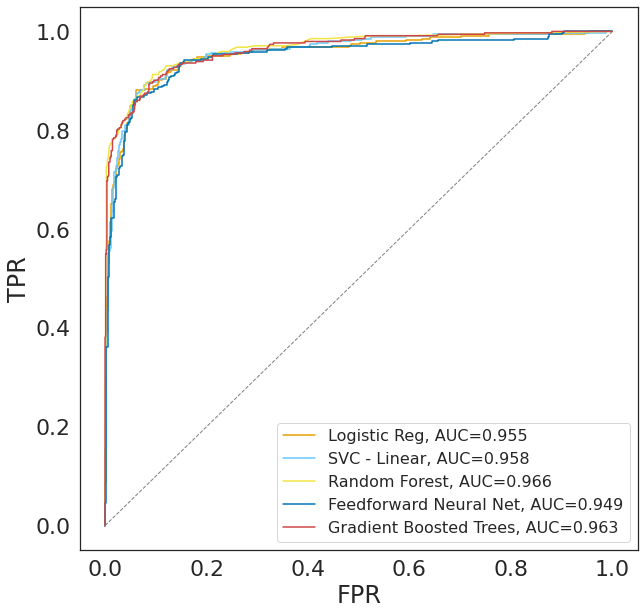

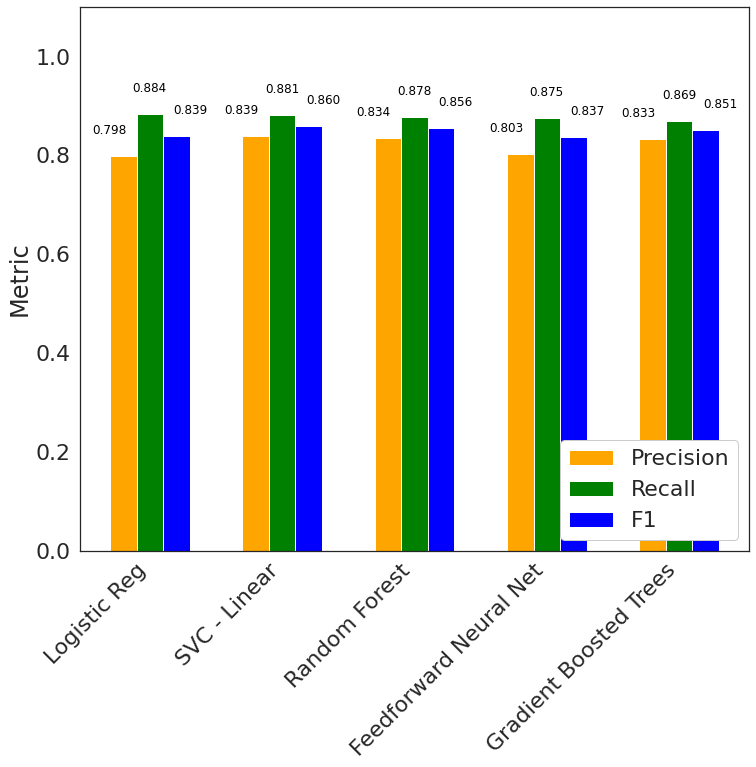

In [72]:
insider_tissue_res_df, _, insider_tissue_predictions_df = generate_analysis_figs(insider_df_tissue_features_annots, 
                                                  grouped_analysis=True,
                                                  downsample_maj=False,
                                                  upsample_min=False,
                                                  weight_imbalance=False,
                                                  in_clf_list=insider_CT_clf_list,
                                                  plot_roc_curve=True,
                                                  plot_confusion_matrices=False,
                                                  plot_feature_analysis=False,
                                                  out_dir=fig_out_dir,
                                                  filename="insiderTissues")



... and look at performance compared to benchmarks

Looking at benchmark: any_rel_con_section_match
Accuracy 0.6286449399656947
Looking at benchmark: is_con_mention_max
Accuracy 0.9150943396226415
Looking at benchmark: con_mention_50
Accuracy 0.9202401372212693
Looking at benchmark: con_in_mesh_headings
Accuracy 0.8147512864493996
Looking at benchmark: min_sent_dist_1
Accuracy 0.7898799313893653
Looking at benchmark: min_sent_dist_2
Accuracy 0.8198970840480274
Looking at benchmark: min_sent_dist_3
Accuracy 0.8319039451114922
Looking at benchmark: min_sent_dist_4
Accuracy 0.8276157804459692
Looking at benchmark: min_sent_dist_5
Accuracy 0.8190394511149228
Looking at benchmark: min_sent_dist_6
Accuracy 0.8087478559176673


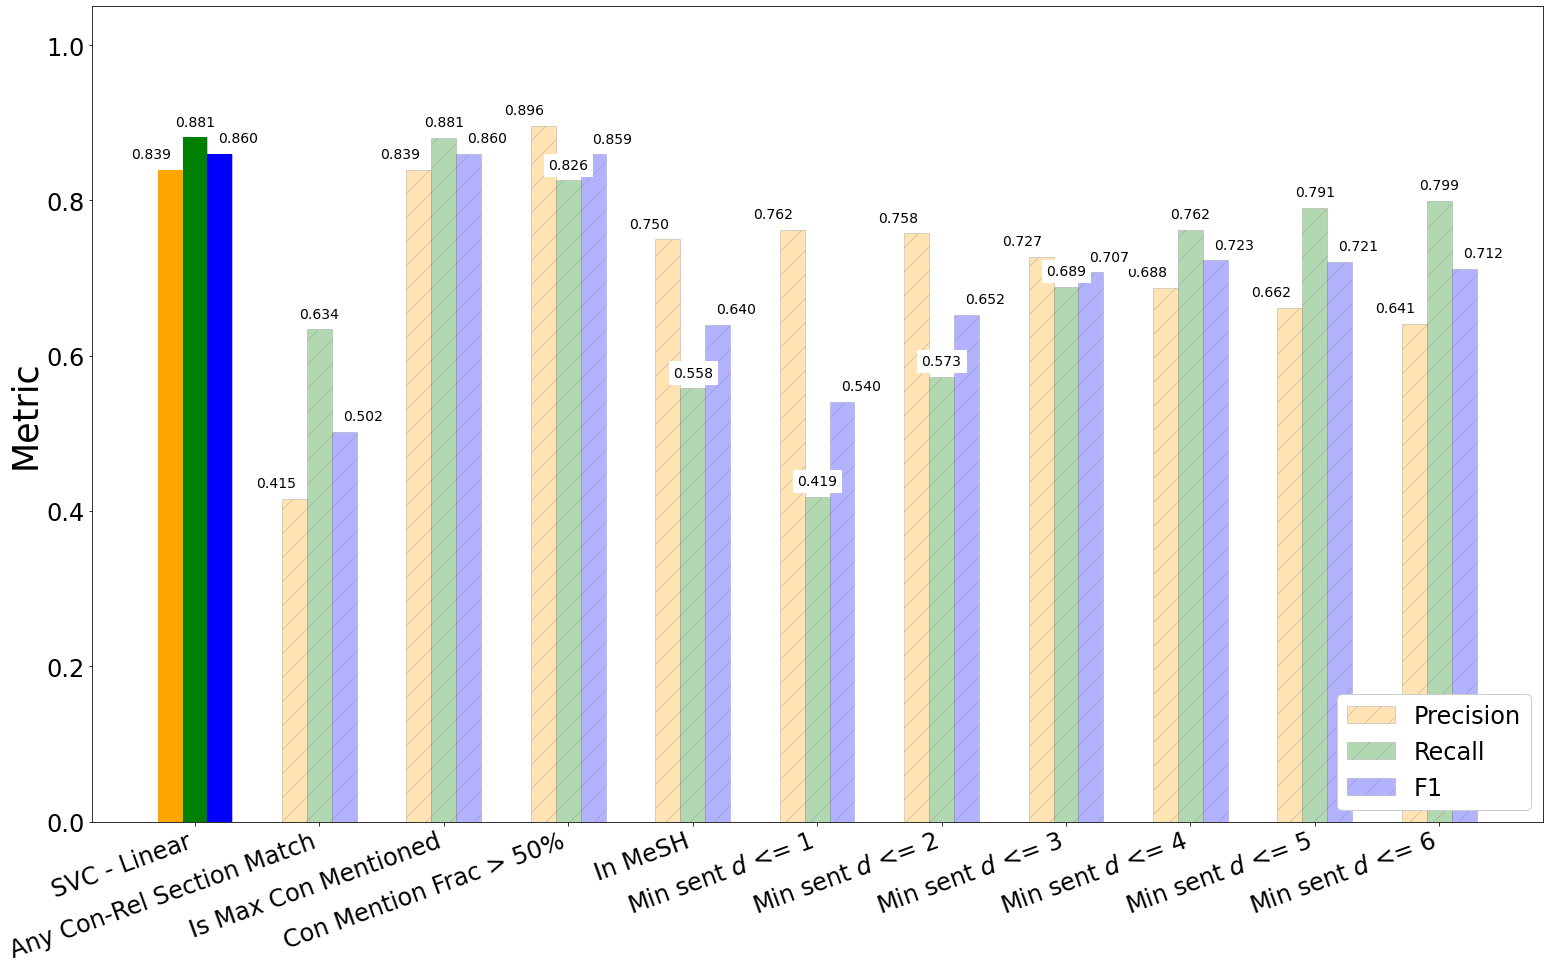

In [17]:
# Check that all the columns are fleshed out since the classifiers will expect the full number of columns

plot_benchmark_fig(insider_tissue_res_df, 
                   best_model_name="SVC - Linear",
                   best_model_stats=[0.839, 0.881, 0.860],
                   out_dir=fig_out_dir,
                   filename="insiderTissues")

#### Now demonstrating improvement over combining the two groups

In this section we look at how performance changes when I mix the two lexicons together as opposed to separating them into single context types.

N negatives: 1130
N positives: 491
Total len of resulting DF: 1621


N negatives - after up/down-weighting: 1130
N positives - after up/down-weighting: 491
Total len of resulting DF: 1621
Initializing list of untrained models...
Fitting model: Logistic Reg
Fitting model: SVC - Linear
Fitting model: Random Forest
Fitting model: Feedforward Neural Net


/Users/dnsosa/opt/miniconda3/envs/lit_con2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Fitting model: Gradient Boosted Trees
Looking at clf: Logistic Reg
Accuracy 0.933456561922366
Looking at clf: SVC - Linear
Accuracy 0.9316081330868762
Looking at clf: Random Forest
Accuracy 0.9371534195933456
Looking at clf: Feedforward Neural Net
Accuracy 0.922365988909427
Looking at clf: Gradient Boosted Trees
Accuracy 0.9297597042513863


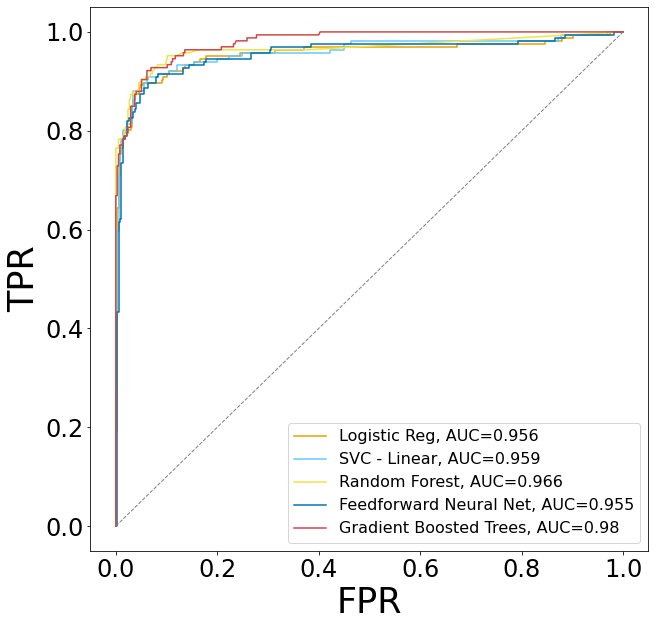

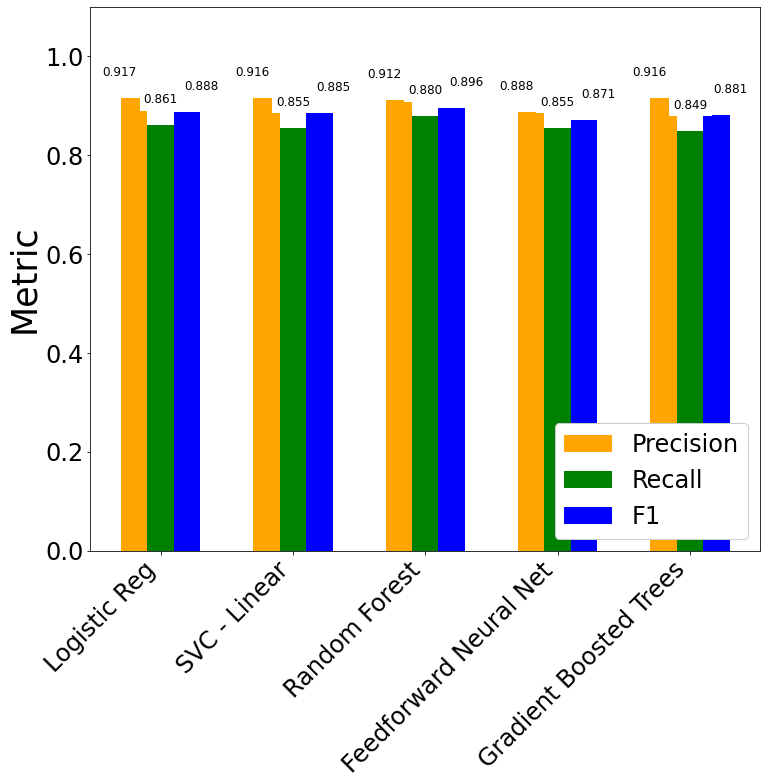

In [18]:
# First, let's recalculate the CT analyses with no downsampling

insider_CT_res_noDown_df, _, _ = generate_analysis_figs(insider_df_CT_features_annots, 
                                                        grouped_analysis=True,
                                                        downsample_maj=False,
                                                        upsample_min=False,
                                                        weight_imbalance=False,
                                                        plot_roc_curve=True,
                                                        plot_confusion_matrices=False,
                                                        plot_feature_analysis=False,
                                                        out_dir=fig_out_dir,
                                                        filename="insiderCT_noDownsample")

N negatives: 3944
N positives: 835
Total len of resulting DF: 4779


N negatives - after up/down-weighting: 3944
N positives - after up/down-weighting: 835
Total len of resulting DF: 4779
Initializing list of untrained models...
Fitting model: Logistic Reg
Fitting model: SVC - Linear
Fitting model: Random Forest
Fitting model: Feedforward Neural Net
Fitting model: Gradient Boosted Trees
Looking at clf: Logistic Reg
Accuracy 0.9290646578782172
Looking at clf: SVC - Linear
Accuracy 0.9278091650973007
Looking at clf: Random Forest
Accuracy 0.9365976145637163
Looking at clf: Feedforward Neural Net
Accuracy 0.933458882611425
Looking at clf: Gradient Boosted Trees
Accuracy 0.9441305712492153


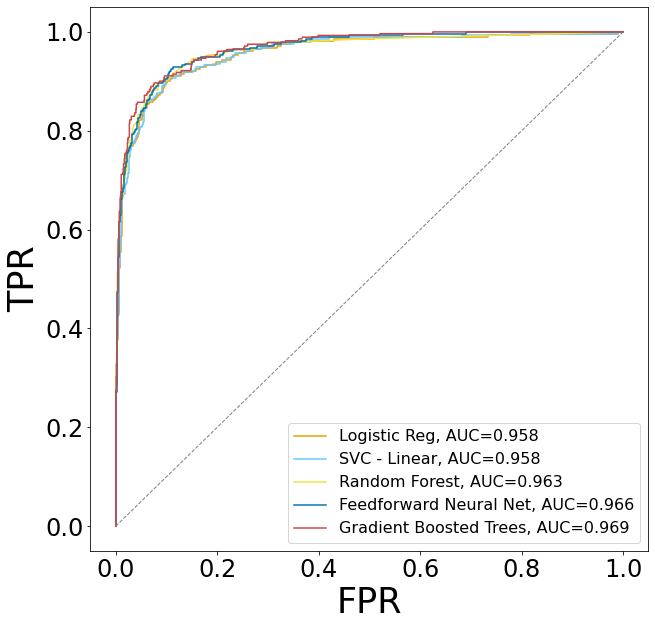

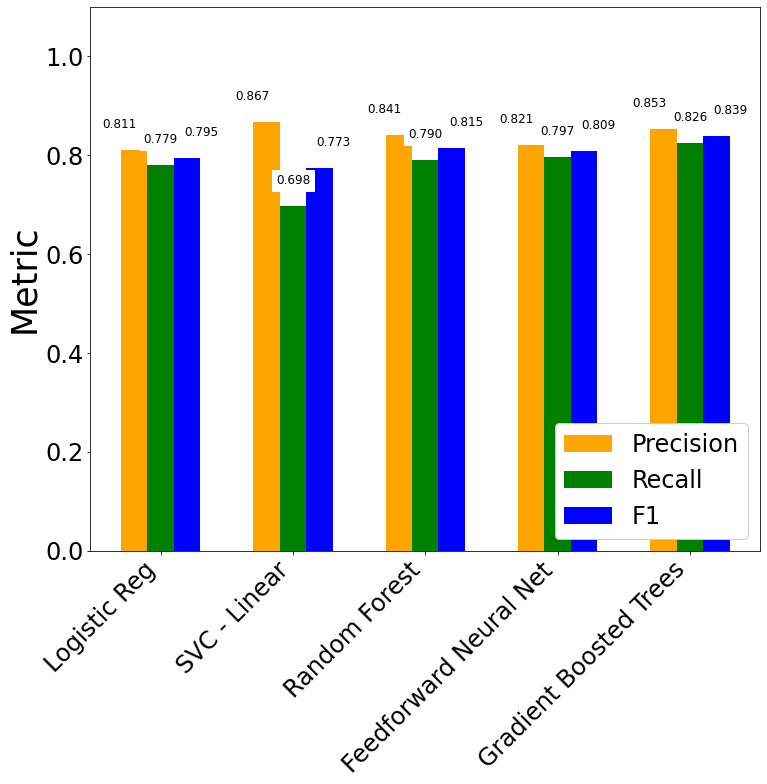

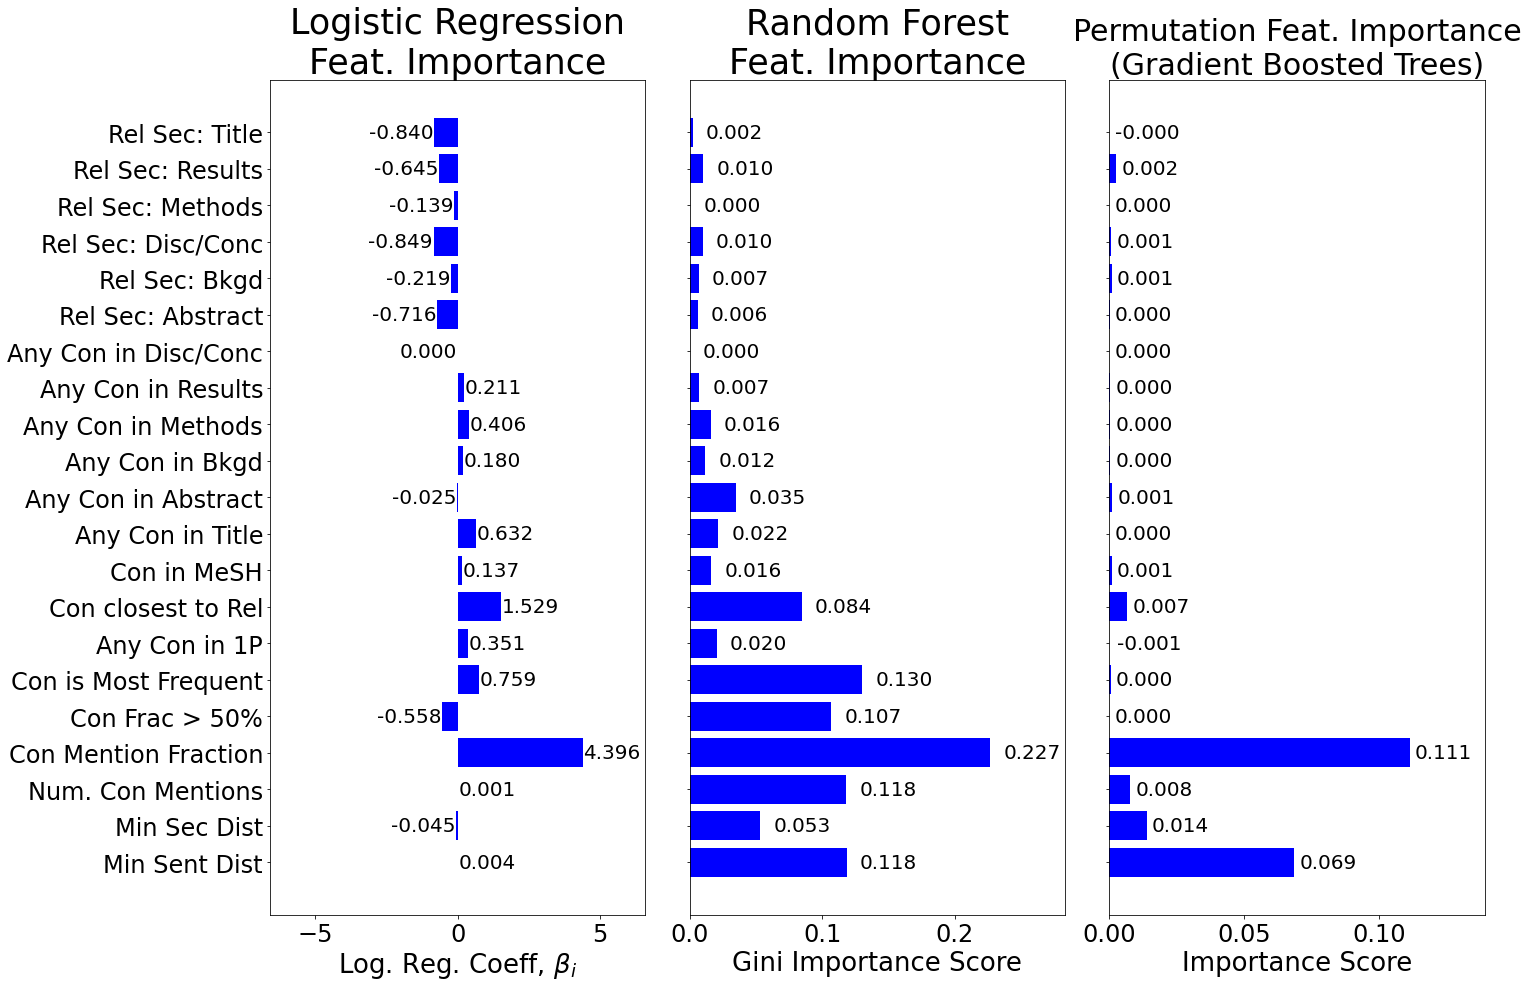

In [19]:
# Let's now calculate the classification results with CT + Tissue types mixed together

insider_df_combined_features_path = os.path.join(out_dir, "combined_insider_papers_features_df.tsv")
insider_df_combined_features = pd.read_csv(insider_df_combined_features_path, sep='\t')

insider_df_combined_positives = pd.concat([insider_df_CTs, insider_df_tissues])

insider_df_combined_features_annots = include_annotations_in_insider_corpus(insider_df_combined_positives, insider_df_combined_features)


insider_combined_res_df, insider_combined_clf_list, insider_combined_predictions_df = generate_analysis_figs(insider_df_combined_features_annots, 
                                                                                           grouped_analysis=True,
                                                                                           downsample_maj=False,
                                                                                           upsample_min=False,
                                                                                           weight_imbalance=False,
                                                                                           plot_roc_curve=True,
                                                                                           plot_confusion_matrices=False,
                                                                                           plot_feature_analysis=True,
                                                                                           out_dir=fig_out_dir,
                                                                                           filename="insiderCombined")

Threshold for 90% recall: 0.447
Precision for 90% recall: 0.898
Threshold for 90% recall: 0.333
Precision for 90% recall: 0.801


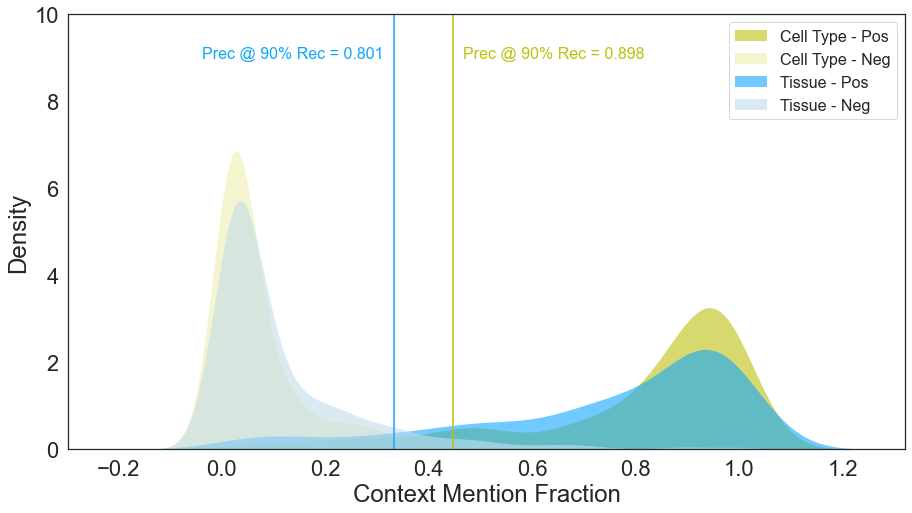

Threshold for 90% recall: 0.193
Precision for 90% recall: 0.619


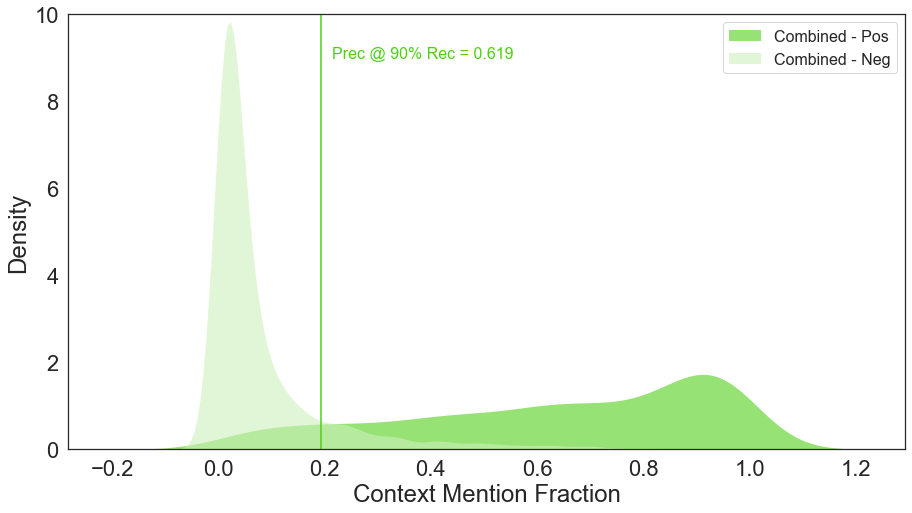

In [22]:
# Finally, let's check out how precision changes using the important context mention fraction feature on the single context type lexicon versus the combined.

plot_con_mention_frac_precision_plots(insider_CT_res_noDown_df, 
                                      insider_tissue_res_df, 
                                      insider_combined_res_df, 
                                      fig_out_dir)


### GIANT Distant Supervision Tissue-PPI Associations

Now let's take a look at using orthogonal context-enriched data under our framework and see how we can find those associations. We'll look at the GIANT (https://giant.princeton.edu/) tissue-specific PPI networks. Given a tissue, $T$, and a PPI in that GIANT PPI network, $r$, we're going to be making the huge assumption that if we see $T$ and $r$ mentioned in the text together, $T$ is an appropriate association for $r$. Qualitative analysis reveals that this assumption is quite strong.

We'll be looking at 3 PPI networks: adipose, liver, and lung. Let's load up all the papers we find containing a
ppi relation, $r$, and one of these three tissues, $T$.

In [23]:
adipose_res_path = os.path.join(out_dir, "adipose_tissue_ppi_pmc_df.csv")
liver_res_path = os.path.join(out_dir, "liver_ppi_pmc_df.csv")
lung_res_path = os.path.join(out_dir, "lung_ppi_pmc_df.csv")

adipose_res = pd.read_csv(adipose_res_path)
liver_res = pd.read_csv(liver_res_path)
lung_res = pd.read_csv(lung_res_path)


adipose_res["context_term"] = "adipose tissue"
adipose_res["context_term_prefix"] = "adipo"

liver_res["context_term"] = "liver"
liver_res["context_term_prefix"] = "liver"

lung_res["context_term"] = "lung"
lung_res["context_term_prefix"] = "lung"

all_res_combined = pd.concat([adipose_res, liver_res, lung_res], ignore_index=True)

Set the confidence cutoff to .5, so we remove some of the noise

In [45]:
print("Adipose:")
adipose_res50 = adipose_res[adipose_res.Conf >= 0.5]
print(len(adipose_res50))

print("\nLiver:")
liver_res50 = liver_res[liver_res.Conf >= 0.5]
print(len(liver_res50))

print("\nLung:")
lung_res50 = lung_res[lung_res.Conf >= 0.5]
print(len(lung_res50))

giant_positives_df = all_res_combined[['rel', 'context_term']]
giant_positives_df.columns = ["Extracted Relation", "Context"]

all_res_combined50 = pd.concat([adipose_res50, liver_res50, lung_res50], ignore_index=True)

ppi_ds_features_df = pd.read_csv(os.path.join(out_dir,  "ppi_pmc_tissues_features_df.csv"))

ppi_ds_features_df50 = ppi_ds_features_df.merge(all_res_combined50, on='rel', how='inner')

Adipose:
258

Liver:
225

Lung:
397


In [47]:
# Now take out any non-citing sentences
non_citing_relations = dl.all_pubmed_relations_df[dl.all_pubmed_relations_df.distance_to_nearest_sentence_with_citation > 0].rel.drop_duplicates()
print(f"Number of unique non-citing relations: {len(non_citing_relations)}")

# Calculate some stats on the number of unique triples
giant_triples = all_res_combined50[['rel', 'pmid', 'context_term']].drop_duplicates()
n_giant_triples_nonciting = len(giant_triples[giant_triples['rel'].isin(non_citing_relations)])
print(len(all_res_combined50))

# Get the final feature and relation collections that will be input for our models
giant_positives_df50 = all_res_combined50[['rel', 'context_term']]
giant_positives_df50.columns = ["Extracted Relation", "Context"]
giant_df_features_annots50 = include_annotations_in_insider_corpus(giant_positives_df50, ppi_ds_features_df50)

print("After 50 filtration")
print(len(giant_df_features_annots50))
giant_df_features_annots50NC = giant_df_features_annots50.merge(non_citing_relations, on="rel", how="inner")
print("and also not citing:")
print(len(giant_df_features_annots50NC))

n_giant_50nc = len(giant_df_features_annots50NC[['rel', 'con', 'paper_id']].drop_duplicates())
print(f"\nSize of the resulting GIANT corpus, .5 conf filter, non-citing: {n_giant_50nc}")
n_giant_50nc_pos = len(giant_df_features_annots50NC[giant_df_features_annots50NC.annotation][['rel', 'con', 'paper_id']].drop_duplicates())
print(f"positives only: {n_giant_50nc_pos}")



Number of unique non-citing relations: 38097
880
After 50 filtration
26577
and also not citing:
9233

Size of the resulting GIANT corpus, .5 conf filter, non-citing: 629
positives only: 217


Evaluate the performance of a model that is retrained on just the GIANT corpus we've created and another that is transferred from the CT data above.

N negatives: 373
N positives: 199
Total len of resulting DF: 572


N negatives - after up/down-weighting: 373
N positives - after up/down-weighting: 199
Total len of resulting DF: 572
norm_rel_sec_title not found in column list. Assigning it a column of falses
norm_rel_sec_abstract not found in column list. Assigning it a column of falses
norm_rel_sec_methods not found in column list. Assigning it a column of falses
List of 5 pre-trained models provided. No need to initialize new models.
Looking at clf: Logistic Reg
Accuracy 0.6923076923076923
Looking at clf: SVC - Linear
Accuracy 0.6713286713286714
Looking at clf: Random Forest
Accuracy 0.6625874125874126
Looking at clf: Feedforward Neural Net
Accuracy 0.6835664335664335
Looking at clf: Gradient Boosted Trees
Accuracy 0.6643356643356644


/Users/dnsosa/opt/miniconda3/envs/lit_con2/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/Users/dnsosa/opt/miniconda3/envs/lit_con2/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/Users/dnsosa/opt/miniconda3/envs/lit_con2/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/Users/dnsosa/opt/miniconda3/envs/

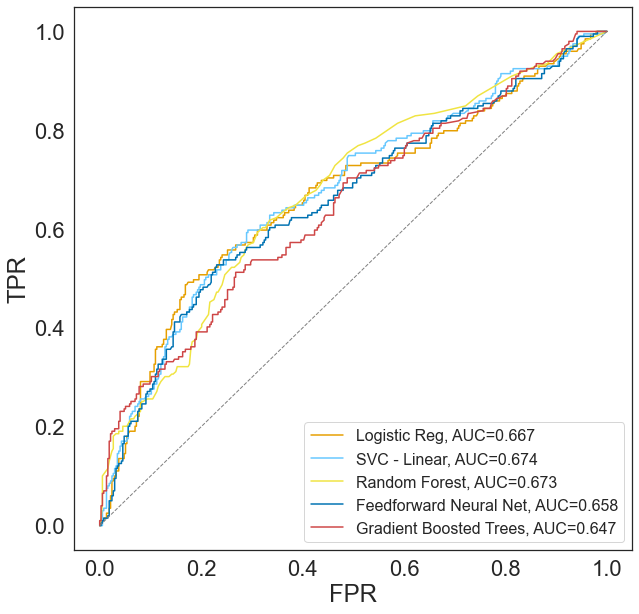

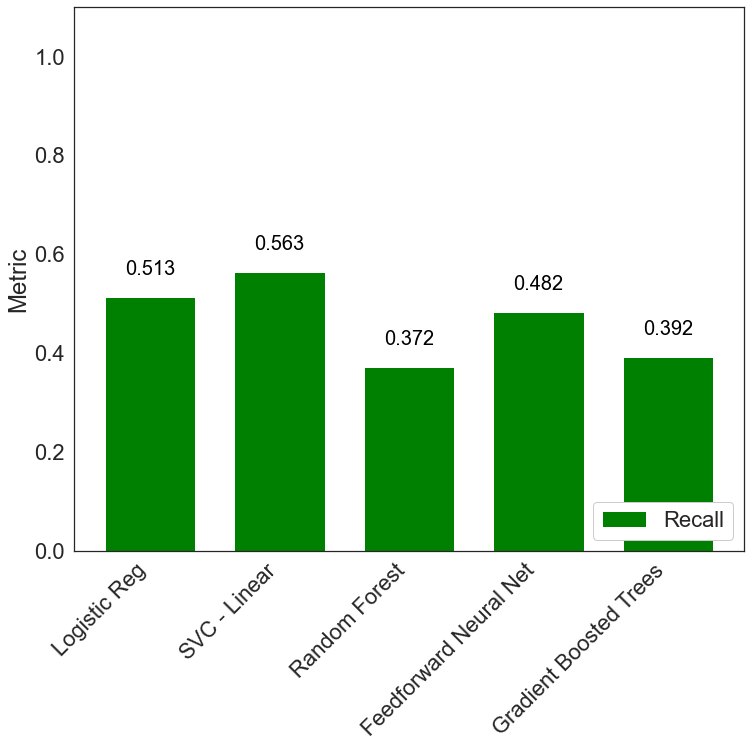

Looking at benchmark: any_rel_con_section_match
Accuracy 0.48426573426573427
Looking at benchmark: is_con_mention_max
Accuracy 0.6713286713286714
Looking at benchmark: con_mention_50
Accuracy 0.701048951048951
Looking at benchmark: con_in_mesh_headings
Accuracy 0.6555944055944056
Looking at benchmark: min_sent_dist_1
Accuracy 0.6520979020979021
Looking at benchmark: min_sent_dist_2
Accuracy 0.6520979020979021
Looking at benchmark: min_sent_dist_3
Accuracy 0.6520979020979021
Looking at benchmark: min_sent_dist_4
Accuracy 0.6573426573426573
Looking at benchmark: min_sent_dist_5
Accuracy 0.6416083916083916
Looking at benchmark: min_sent_dist_6
Accuracy 0.6381118881118881


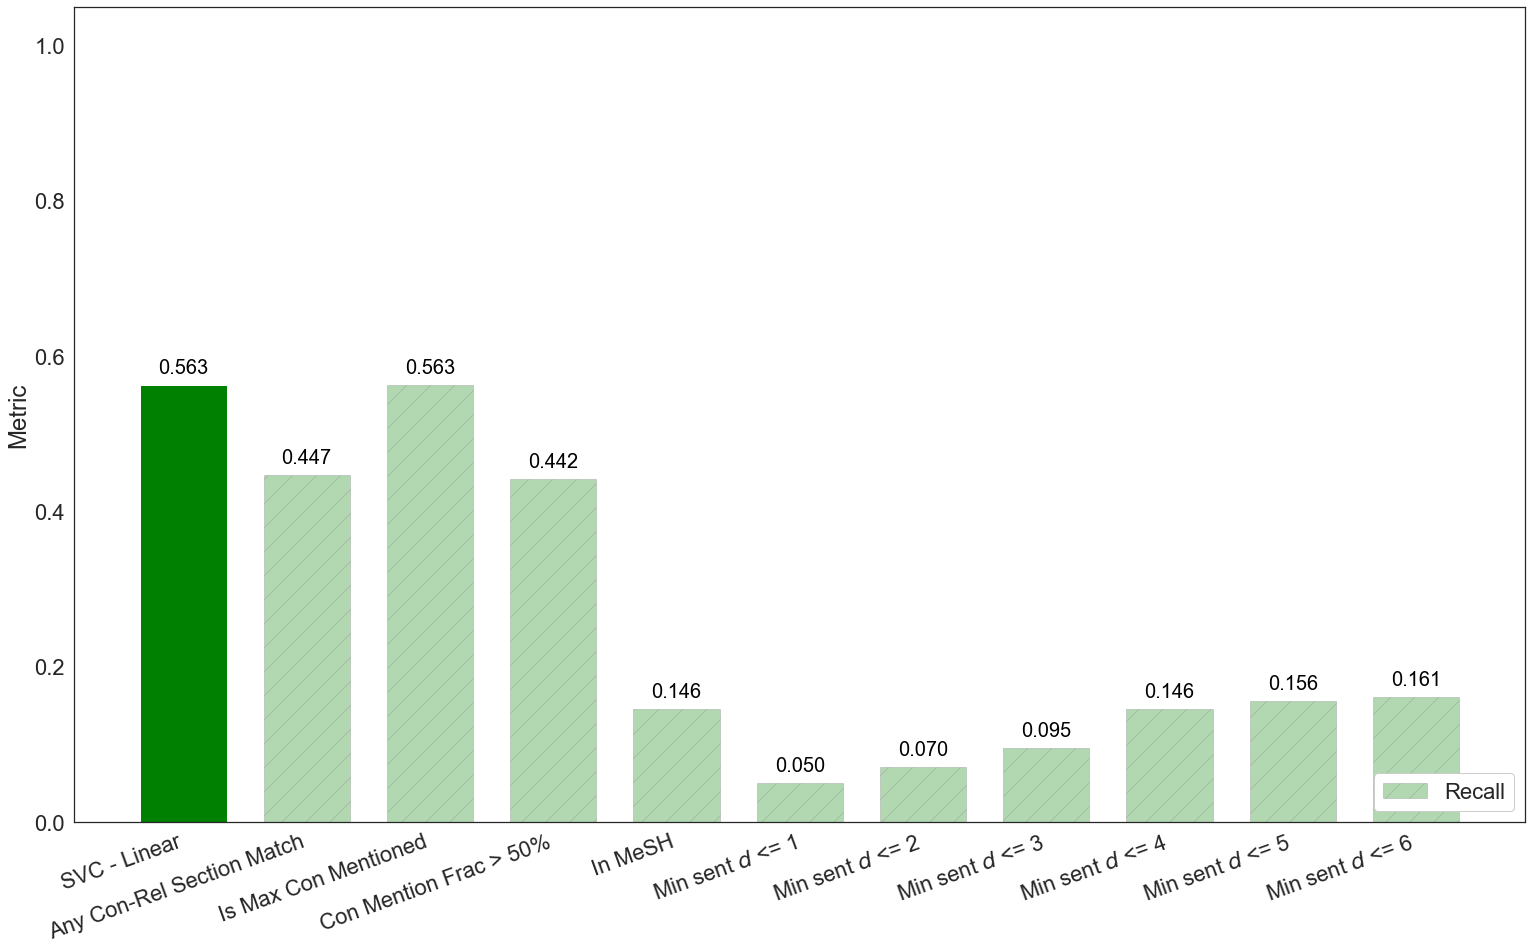

N negatives: 373
N positives: 199
Total len of resulting DF: 572


N negatives - after up/down-weighting: 199
N positives - after up/down-weighting: 199
Total len of resulting DF: 398
norm_rel_sec_title not found in column list. Assigning it a column of falses
norm_rel_sec_abstract not found in column list. Assigning it a column of falses
norm_rel_sec_methods not found in column list. Assigning it a column of falses
Initializing list of untrained models...
Fitting model: Logistic Reg
Fitting model: SVC - Linear
Fitting model: Random Forest
Fitting model: Feedforward Neural Net
Fitting model: Gradient Boosted Trees
Looking at clf: Logistic Reg
Accuracy 0.5714285714285714
Looking at clf: SVC - Linear
Accuracy 0.5639097744360902
Looking at clf: Random Forest
Accuracy 0.556390977443609
Looking at clf: Feedforward Neural Net
Accuracy 0.5639097744360902
Looking at clf: Gradient Boosted Trees
Accuracy 0.6015037593984962


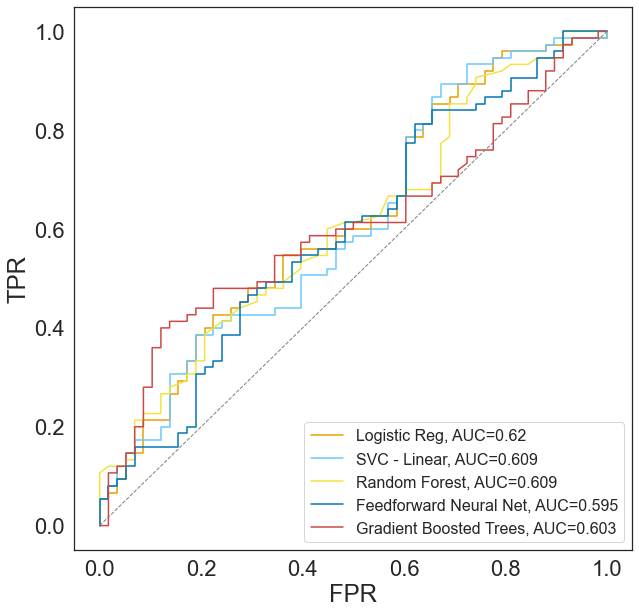

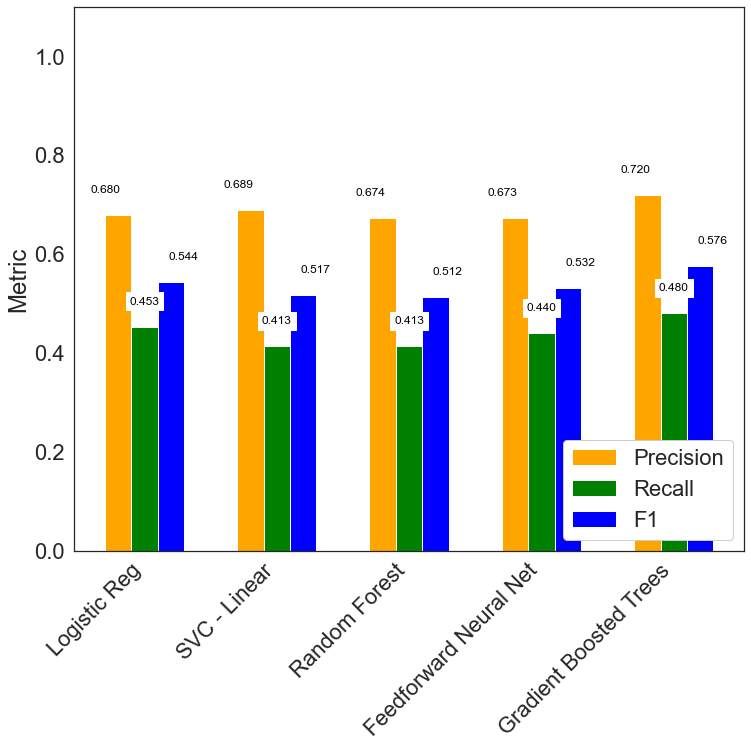

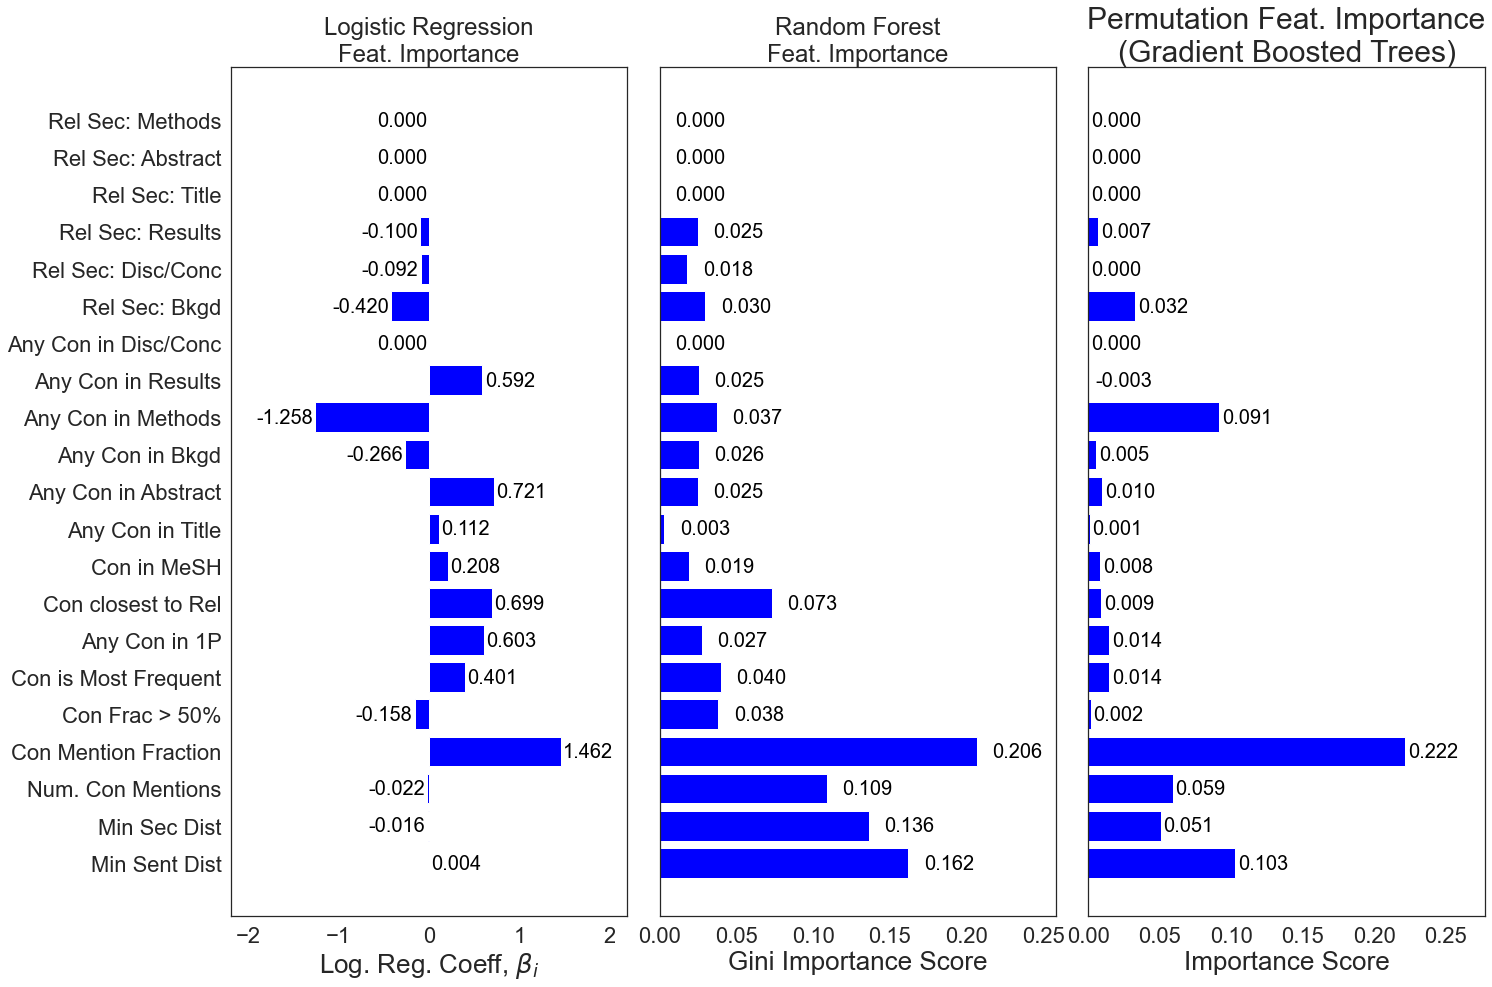

Looking at benchmark: any_rel_con_section_match
Accuracy 0.4623115577889447
Looking at benchmark: is_con_mention_max
Accuracy 0.6532663316582915
Looking at benchmark: con_mention_50
Accuracy 0.6482412060301508
Looking at benchmark: con_in_mesh_headings
Accuracy 0.5376884422110553
Looking at benchmark: min_sent_dist_1
Accuracy 0.507537688442211
Looking at benchmark: min_sent_dist_2
Accuracy 0.5100502512562815
Looking at benchmark: min_sent_dist_3
Accuracy 0.5175879396984925
Looking at benchmark: min_sent_dist_4
Accuracy 0.5301507537688442
Looking at benchmark: min_sent_dist_5
Accuracy 0.5150753768844221
Looking at benchmark: min_sent_dist_6
Accuracy 0.5125628140703518


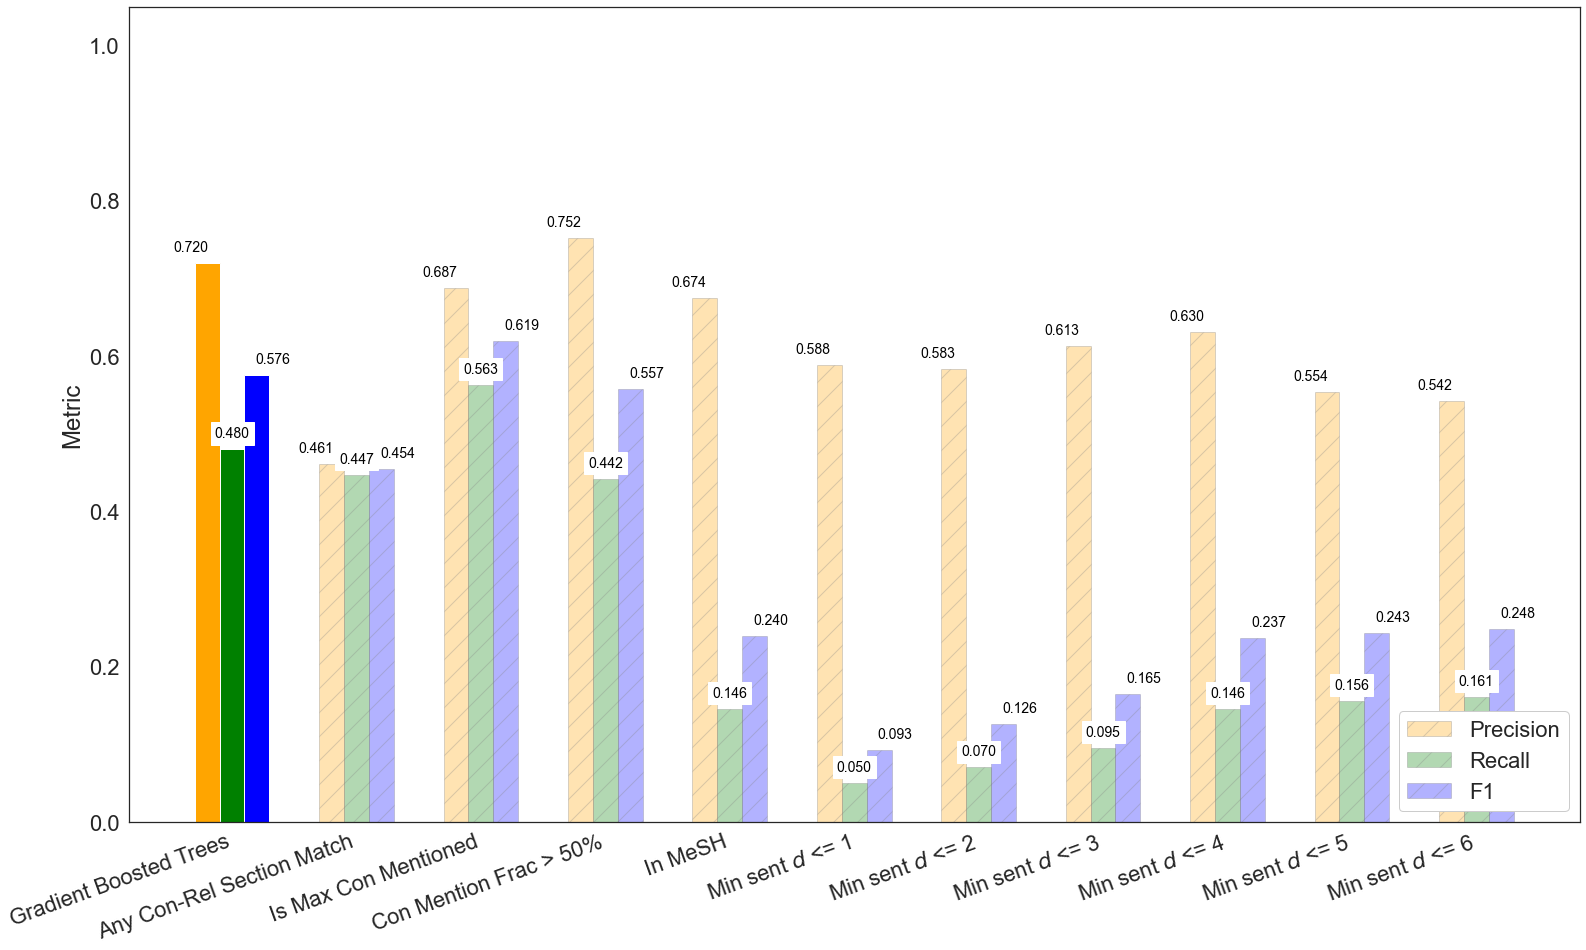

In [44]:
giant_res_df50NC_transfer, _, _ = generate_analysis_figs(giant_df_features_annots50NC, 
                                                grouped_analysis=True,
                                                downsample_maj=False,
                                                upsample_min=False,
                                                weight_imbalance=False,
                                                in_clf_list=insider_CT_clf_list,
                                                plot_roc_curve=True,
                                                plot_confusion_matrices=False,
                                                plot_feature_analysis=False,
                                                recall_only=True,
                                                out_dir=fig_out_dir,
                                                filename="giantTransfer50NC")


plot_benchmark_fig(giant_res_df50NC_transfer, 
                  best_model_name="SVC - Linear", 
                  best_model_stats=[.563],
                  recall_only=True,
                  out_dir=fig_out_dir,
                  filename="giantTransfer50NC")

giant_res_df50NC_retrain, _, _ = generate_analysis_figs(giant_df_features_annots50NC, 
                                                grouped_analysis=True,
                                                downsample_maj=True,
                                                upsample_min=False,
                                                weight_imbalance=False,
                                                plot_roc_curve=True,
                                                plot_confusion_matrices=False,
                                                plot_feature_analysis=True,
                                                recall_only=False,
                                                out_dir=fig_out_dir,
                                                filename="giantRetrain50NC")

plot_benchmark_fig(giant_res_df50NC_retrain, 
                   best_model_name="Gradient Boosted Trees", 
                   best_model_stats=[.720, .480, .576],
                   out_dir=fig_out_dir,
                   filename="giantRetrain50NC")

### Deconvolving Cell Type Contexts for Dengue Fever Etiology 

Finally, let's take a look at applying our pipeline to an example slice of literature--PPIs relevant in host response to Dengue infection. Specifically let's see which cell types these interactions we find in literature come from.

Dengue_pps_df network has: 89971 directed edges
There are: 5853 unique genes in this network
querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-5853...done.
Finished.
1 input query terms found dup hits:
	[('FCGR2C', 2)]
22 input query terms found no hit:
	['UHRF1BP1L', 'MT-ND3', 'DDX58', 'MT-ND5', 'MT-ND2', 'MYLPF', 'ARNTL', 'MT-CO3', 'TTC37', 'MT-CO2', 
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
Retrieved a mapping from Entrez to gene symbols
Input: 88774 dengue-related PPIs
After taking subset of relations, need to extract features from: 8787 papers
From this list found 11674 dengue relations
N negatives: 12470
N positives: 0
Total len of resulting DF: 12470


N negatives - after up/down-weighting: 12470
N positives - after up/down-weighting: 0
Total len of resulting DF: 12470
List of 5 pre-trained models provided. No need to initialize new models.
L

/Users/dnsosa/opt/miniconda3/envs/lit_con2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dnsosa/opt/miniconda3/envs/lit_con2/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1016: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/dnsosa/opt/miniconda3/envs/lit_con2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dnsosa/opt/miniconda3/envs/lit_con2/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1016: UndefinedMetricWarning

Accuracy 0.6914995990376904
Looking at clf: Feedforward Neural Net
Accuracy 0.6170809943865276
Looking at clf: Gradient Boosted Trees
Accuracy 0.7268644747393745


/Users/dnsosa/opt/miniconda3/envs/lit_con2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dnsosa/opt/miniconda3/envs/lit_con2/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1016: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/dnsosa/opt/miniconda3/envs/lit_con2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dnsosa/opt/miniconda3/envs/lit_con2/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1016: UndefinedMetricWarning

<Figure size 720x720 with 0 Axes>

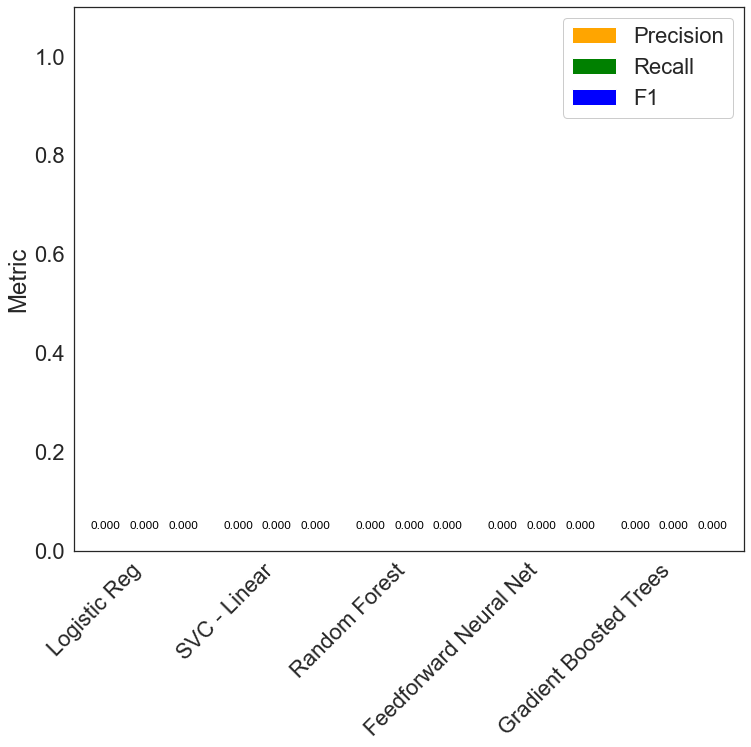

In [53]:
# Load up the corpus of PPIs and the relations we've found with our dependency parse method that contain these two gene/proteins.
dengue_ppis_df = create_dengue_corpus()
print(f"Input: {len(dengue_ppis_df)} dengue-related PPIs")
dengue_relations_df = dl.get_relation_subset_from_ppi_intersect(subset_df=dengue_ppis_df)
print(f"From this list found {len(dengue_relations_df)} dengue relations")

#dengue_features_df_path = "/Users/dnsosa/Desktop/AltmanLab/bai/Stanford-Collab/output/dengue_papers_features_df.tsv"
dengue_features_df_path = os.path.join(out_dir, "dengue_papers_features_df.tsv")
dengue_features_df = pd.read_csv(dengue_features_df_path, sep='\t')
dengue_features_df['annotation'] = False  # Placeholder

# Transferring the model from the CT-Insider corpus here
_, _, dengue_predictions_df = generate_analysis_figs(dengue_features_df, 
                                                     grouped_analysis=True,
                                                     downsample_maj=False,
                                                     upsample_min=False,
                                                     weight_imbalance=False,
                                                     in_clf_list=insider_CT_clf_list,
                                                     plot_roc_curve=True,
                                                     plot_confusion_matrices=False,
                                                     plot_feature_analysis=False,
                                                     in_loc="upper right")


In [59]:
# Taking a closer look at the predicted associations

dengue_relations_df_small = dengue_relations_df[["rel", "entity1_text", "entity2_text", "entity1_entrez", "entity2_entrez"]]

col_list = ["rel", "entity1_text", "entity2_text", "entity1_entrez", "entity2_entrez", "con", "Pred: Random Forest"]
dengue_conned_rels_df = dengue_predictions_df.merge(dengue_relations_df_small, on="rel", how="inner")[col_list]

dengue_edgelist = dengue_conned_rels_df[dengue_conned_rels_df["Pred: Random Forest"]]
print(f"The random forest transferred from the Insider CT training yielded: {len(dengue_edgelist)} context associations")
for in_con in ["macrophage", "hepatocyte", "neutrophil"]:
    print(f"...{len(dengue_edgelist[dengue_edgelist.con == in_con])} from {in_con}")
    
dengue_edgelist.head(5)


The random forest transferred from the Insider CT training yielded: 4400 context associations
...1577 from macrophage
...466 from hepatocyte
...270 from neutrophil


,rel,entity1_text,entity2_text,entity1_entrez,entity2_entrez,con,Pred: Random Forest
0,"Treatment with anti-IL5 antibody, that reduced the number of submucosal eosinophils in patients with asthma, was associated with a reduction in TGF-β levels in bronchoalveolar lavage fluid 34 , indicating that TGF-β may be induced by IL-5.",TGF-β,IL-5,27035,50507,neutrophil,True
3,"These results indicate that IL-18 enhances YY1 expression via NF-κB, leading to the repression of FXR expression by elevated YY1, resulting in reduced of MRP2 expression.",IL-18,YY1,183,2597,hepatocyte,True
7,"In order to detect whether type I IFN (IFN-α/β) can induce ATX expression directly, the THP-1 cells were treated with IFN-α and IFN-β respectively.",IFN,ATX,3553,3606,macrophage,True
9,"ATX expression was induced quickly by IFN-α, peaked at 2h of treatment and then decreased, while during IFN-β treatment ATX expression was increased continually, achieved high levels after 8h treatment and then kept at the high levels.",ATX,IFN-α,728,3605,macrophage,True
11,A PPAR γ antagonist increased eNOS expression in adipocytes and suppressed HFD-induced fatty liver changes.,PPAR γ,eNOS,930,4907,hepatocyte,True


Do we find relations that are uniquely mapped to just one of the three contexts, or are they often predicted to be associated with all 3 contexts at the same time, for example?

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


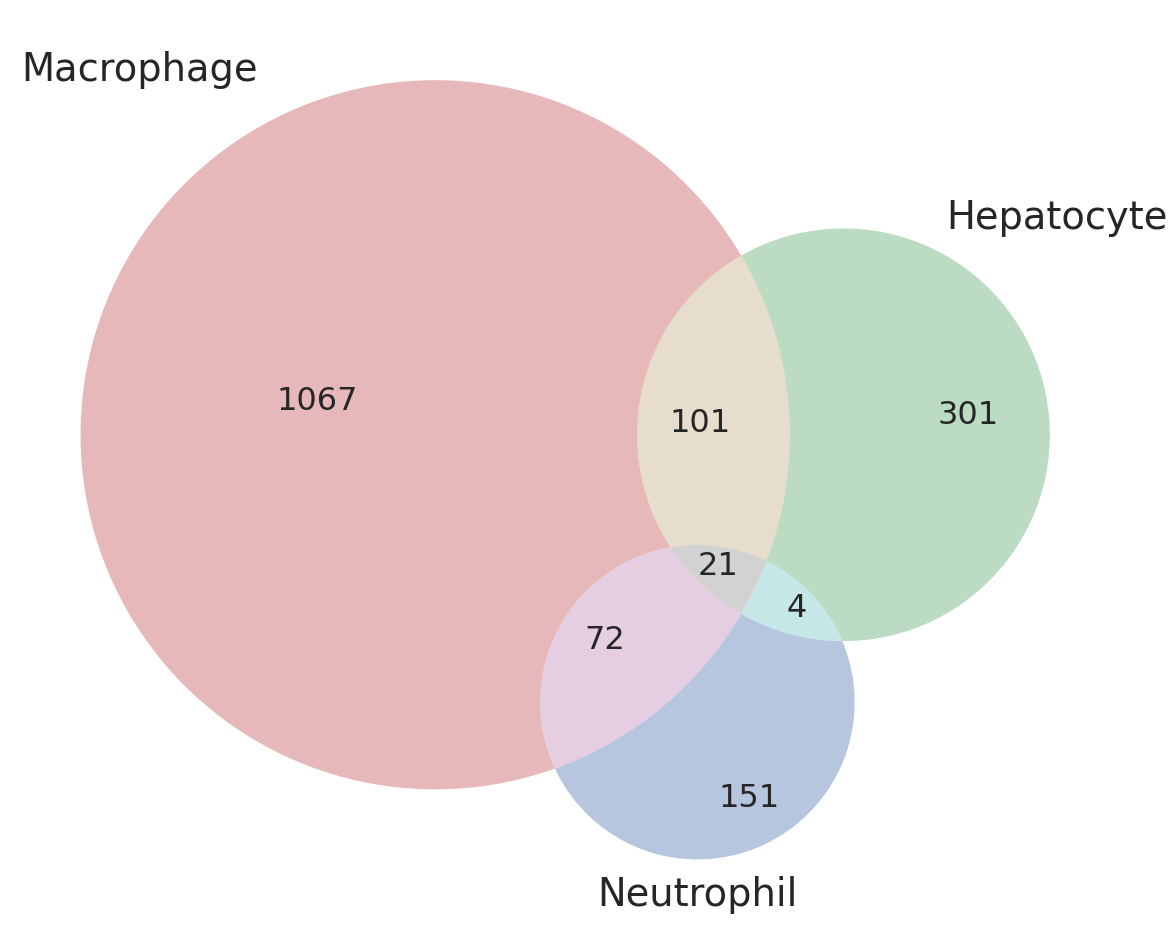

In [57]:
plot_mac_hep_neu_venn(dengue_edgelist, fig_out_dir, dpi=300)

And at last we can visualize a subnetwork where we highlight pieces that have a particular cell type association, which will help us disentangle which parts of the mechanism are involved with which cells!

In [67]:
import os

import itertools
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns

from collections import Counter
from matplotlib_venn import venn3
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.inspection import permutation_importance
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.utils import resample
from sklearn.metrics import ConfusionMatrixDisplay

def plot_dengue_networks(dengue_edgelist, fig_out_dir, min_deg=5, max_deg=15, dpi=300):
    plt.rcParams["figure.figsize"] = (20, 20)

    G_dengue = nx.from_pandas_edgelist(dengue_edgelist, 'entity1_text', 'entity2_text', ['con'])
    mid_degree_nodes = [n for n, d in G_dengue.degree if min_deg <= d <= max_deg]

    G_dengue_sub = G_dengue.subgraph(list(mid_degree_nodes))
    Gcc = G_dengue_sub.subgraph(max(nx.connected_components(G_dengue_sub), key=len)).copy()
    Gcc.remove_edges_from(nx.selfloop_edges(Gcc))

    pos = nx.spring_layout(Gcc, seed=44)

    min_ct_count = 200
    color_palette = ["#D81B60", "#1E88E5", "#FFC107", "#004D40", "#90AB78", "#7B93B9"]
    common_cts = [CT for CT, count in Counter(dengue_edgelist.con).most_common() if count >= min_ct_count]
    ct_color_mapper = dict(zip(common_cts, color_palette))

    nx.draw_networkx_nodes(Gcc, pos, node_size=60, node_color='gray', alpha=1)
    nx.draw_networkx_edges(Gcc, pos, alpha=0.5)
    plt.axis('off')

    out_file = os.path.join(fig_out_dir, "DengueAllCTsSubnet.png")
    plt.savefig(out_file, dpi=dpi, bbox_inches="tight")
    plt.show()

    for ct in ['macrophage', 'hepatocyte', 'neutrophil']:
        nx.draw_networkx_nodes(Gcc, pos, node_size=60, node_color='gray', alpha=0.25)

        edge_colors = []
        edge_widths = []

        for e in Gcc.edges(data=True):
            e_con = e[2]['con']
            if e_con == ct:
                edge_colors.append(ct_color_mapper.get(e_con, 'gray'))
                edge_widths.append(5)
            else:
                edge_colors.append('gray')
                edge_widths.append(1)
        nx.draw_networkx_edges(Gcc, pos, alpha=0.5, edge_color=edge_colors, width=edge_widths, label=ct)

        ct_edge_set = set([(e[0], e[1]) for e in Gcc.edges(data=True) if e[2]['con'] == ct])
        ct_node_set = set(itertools.chain(*ct_edge_set))

        labels = {k: k for k in ct_node_set}
        nx.draw_networkx_labels(Gcc, pos, labels, font_size=25)

        plt.axis('off')

        out_file = os.path.join(fig_out_dir, f"Dengue_{ct}_subnet.png")
        plt.savefig(out_file, dpi=dpi, bbox_inches="tight")
        plt.show()


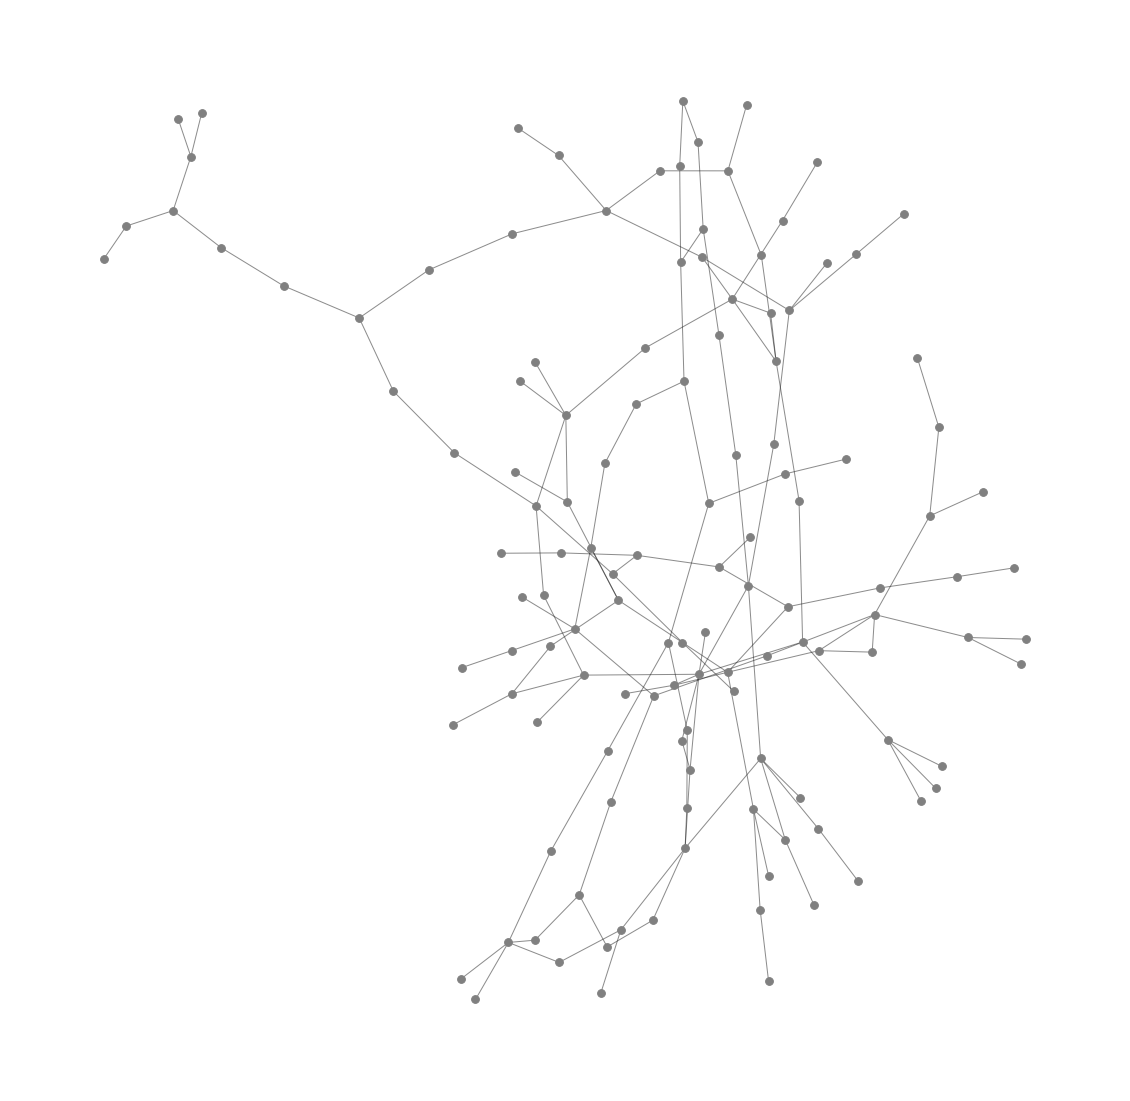

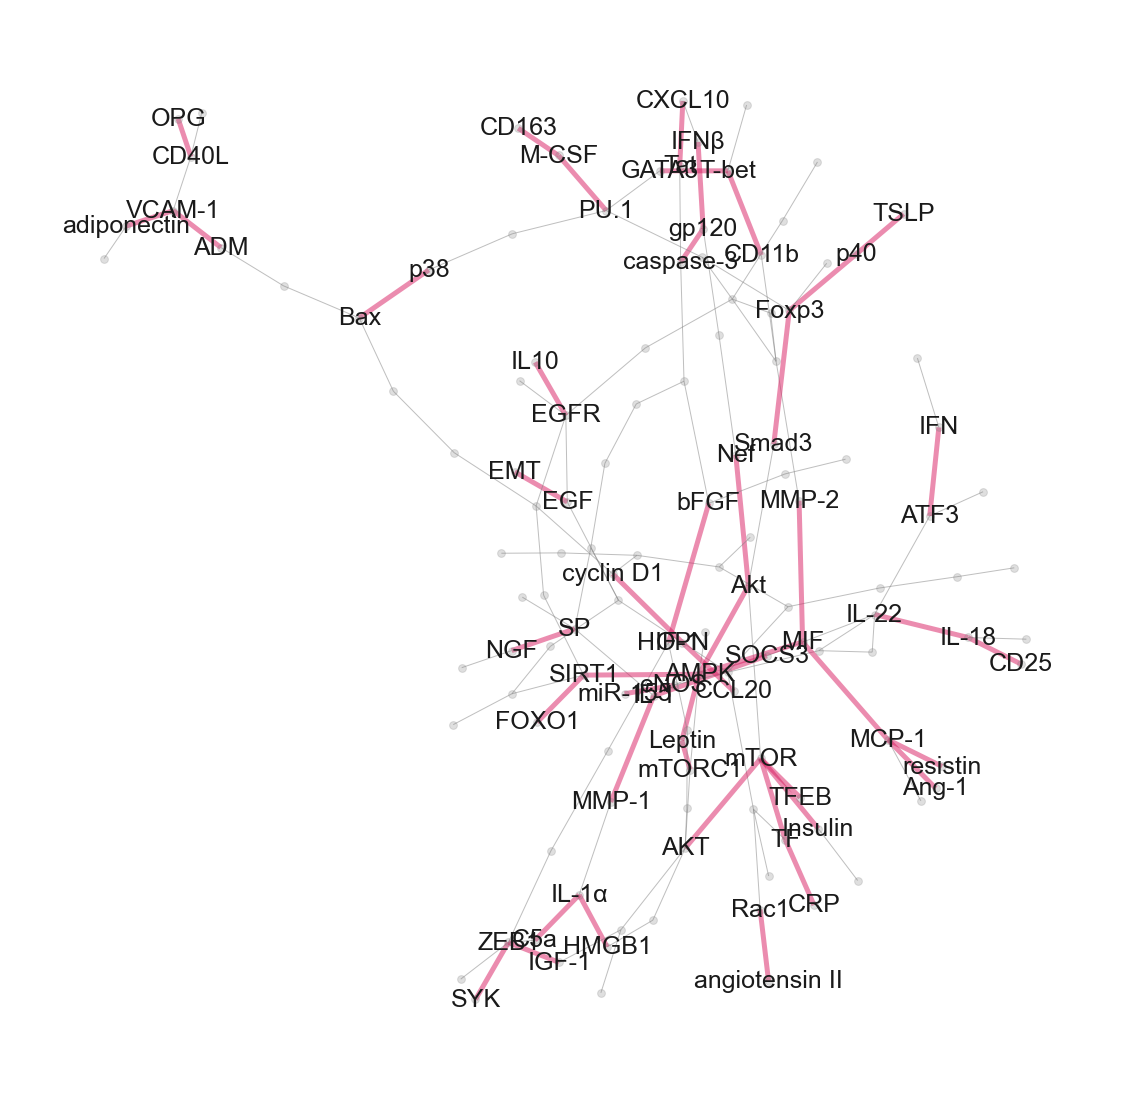

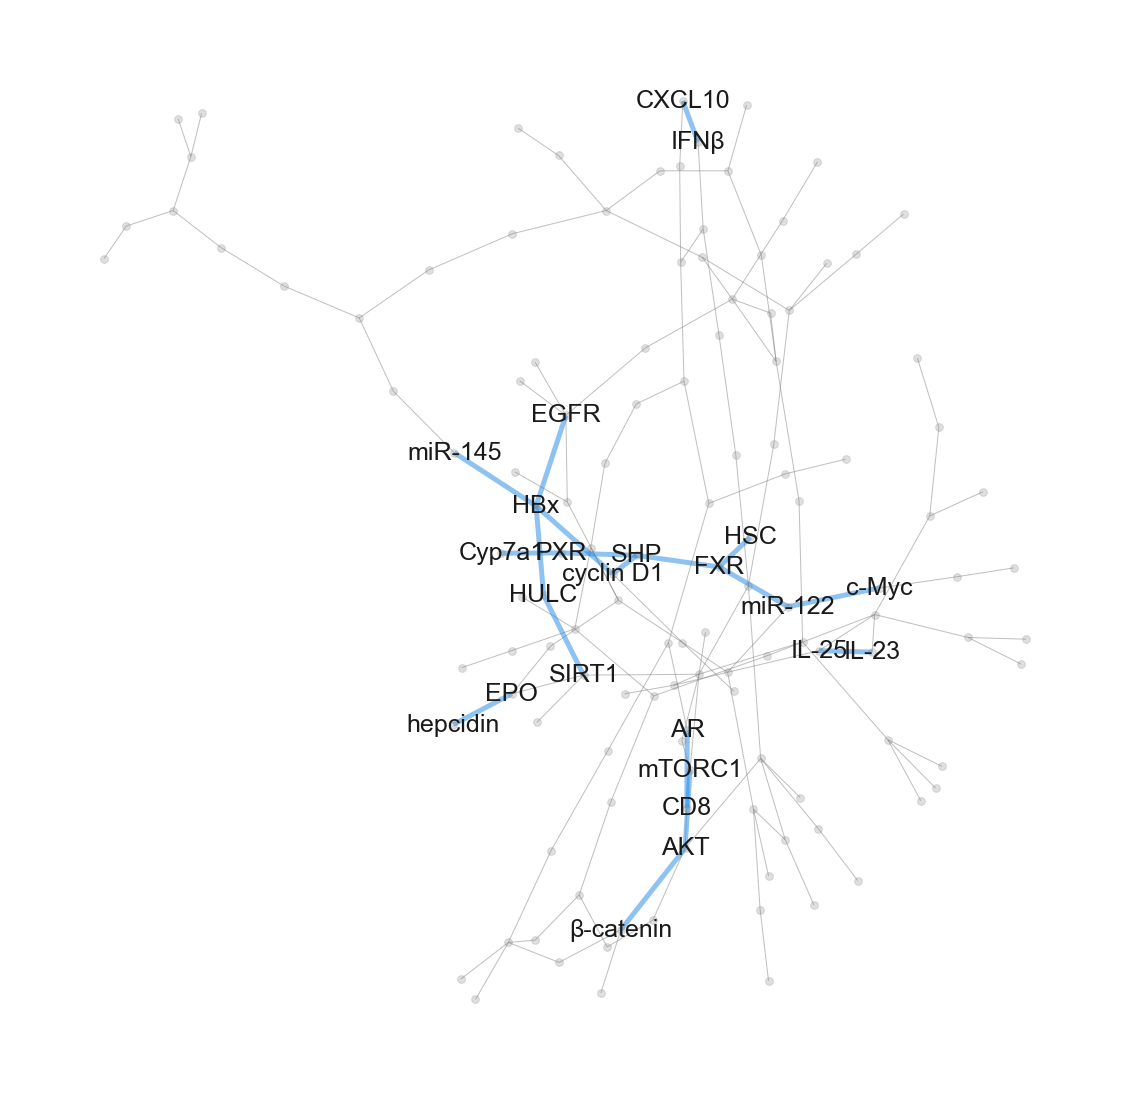

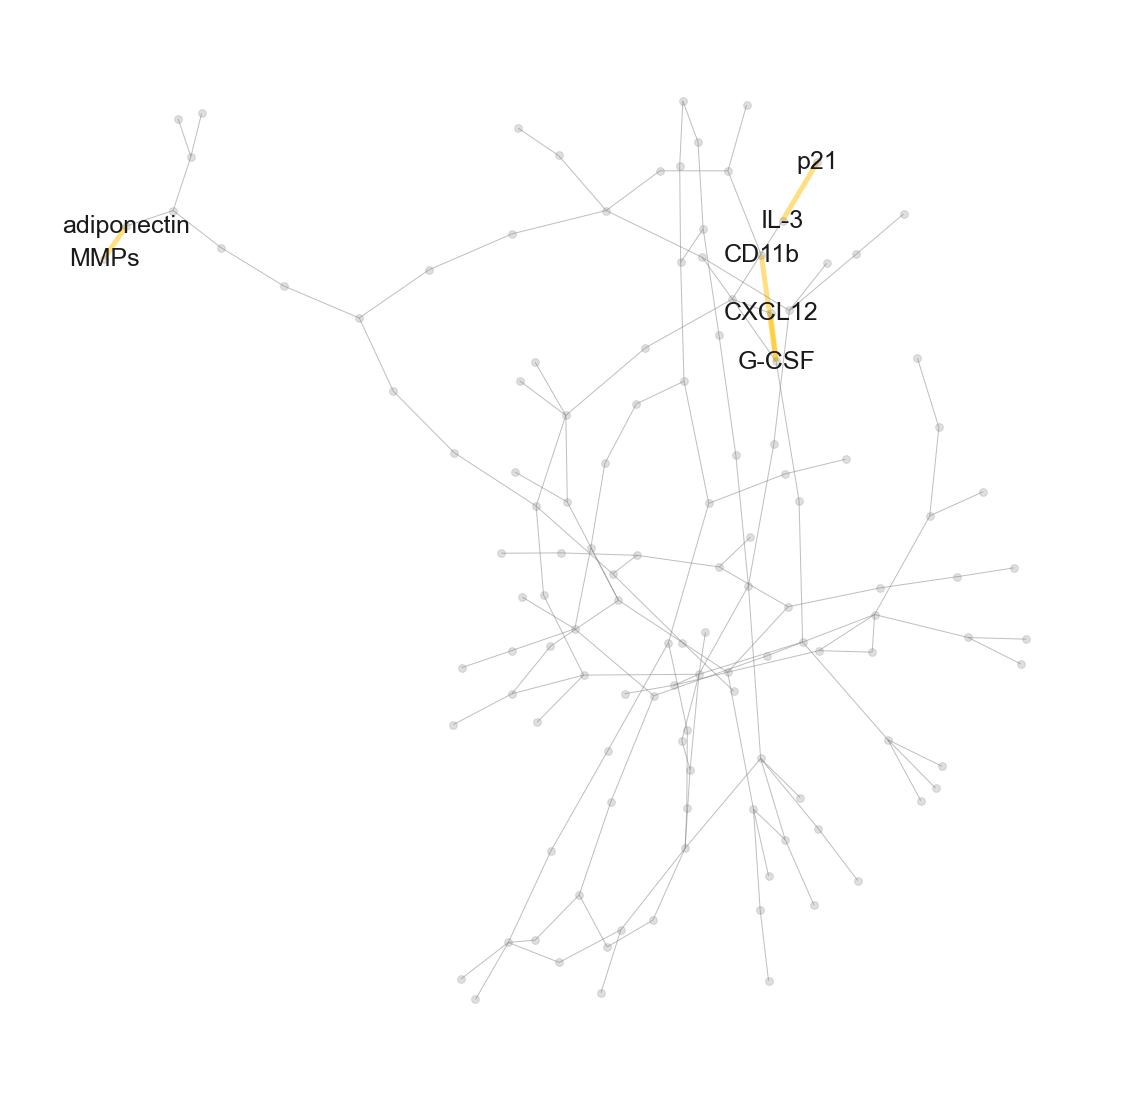

In [68]:
plot_dengue_networks(dengue_edgelist, fig_out_dir)